## IS Full Temp Analysis Outline

Notebook to analyze d1 forward bias impedance data

We begin by importing the data in the correct units below. **Units are *key* in this analysis**. Impedance $Z$ will be presented in $k\Omega cm^{2}$, meaning that $Q$ will acquire units of $k\Omega^{-1} cm^{-2} s^{\alpha}$. The units will be noted in comment blocks.

In [17]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [18]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import os
%matplotlib inline

#to make fonts from plots look normal
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Calibri'
mpl.rcParams['mathtext.it'] = 'Calibri:italic'
mpl.rcParams['mathtext.bf'] = 'Calibri:bold'

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 36}
        #'sans-serif' : 'Arial Unicode MS'}
mpl.rc('font', **font)
plt.rc('font', size=36)          # controls default text sizes

#mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.markersize'] = 16
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['xtick.top'] = False
#mpl.rcParams['ytick.right'] = False

os.chdir(r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\analysis_work\TBAI\06_2016_m3_d2\data_sets\data')

# os.listdir()
tmax = 16
T = np.linspace(180,180+(10*tmax),tmax,endpoint=False)
devNum = 1
voltage1 = 400
# voltage2 = 500
# voltage3 = 600

nPoints = 100
master = np.zeros((tmax,nPoints,5))
# master500mv = np.zeros((tmax,nPoints,5))
# master600mv = np.zeros((tmax,nPoints,5))

is400 = np.zeros((tmax,nPoints,4))
# is500 = np.zeros((tmax,nPoints,4))
# is600 = np.zeros((tmax,nPoints,4))

# # the tmp data has the following format:
# #      index 0 is frequency in rad/s
# #      index 1 is capacitance, C
# #      index 2 is susceptance, B
# #      index 3 is dissipation, D
# #      index 4 is conductance, G

# # we create arrays to hold the impedance data (isv1/isv2) with the following format:
# #      index 0 is Re(Z) in kOhm*cm^2
# #      index 1 is Im(Z) in kOhm*cm^2
# #      index 2 is |Z| in kOhm*cm^2
# #      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master[t,:,0] = tmp1[2:,0]
    master[t,:,1] = savitzky_golay(tmp1[2:,1],51,5)
    master[t,:,2] = savitzky_golay(tmp1[2:,2],51,5)
    master[t,:,3] = savitzky_golay(tmp1[2:,3],51,5)
    master[t,:,4] = savitzky_golay(tmp1[2:,4],51,5)

    is400[t,:,0] = ((master[t,:,4]/((master[t,:,4]**2) + (master[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,1] = ((-master[t,:,2]/((master[t,:,4]**2) + (master[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,2] = np.sqrt((is400[t,:,0]**2) + (is400[t,:,1]**2))
    is400[t,:,3] = -np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)

## Function definitions

def Zr(T):
    return is400[T,:,0]
def Zi(T):
    return is400[T,:,1]
def Zmag(T):
    return is400[T,:,2]
def phi(T):
    return is400[T,:,3]
def w(T):
    return master[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.viridis(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\ligand_manuscript\currentVersion\TBAI\impedance\d2'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 0
off1 = 4
off2 = 12

# Estimate $R_{s}$ by taking the highest frequency value of $Z_{r}$
RsEst = np.zeros(tmax)

for t in range (0,tmax): 
    RsEst[t] = Zr(t)[-1]
    
# define functions to output the magnitude and phase angle of the Rs-corrected plots.   
def ZmagAdj(T):
    return np.sqrt(((is400[T,:,0]-RsEst[T])**2) + (is400[T,:,1]**2))

def phiAdj(T):
    return -np.arctan(is400[T,:,1]/(is400[T,:,0]-RsEst[T]))*(180/np.pi)



  
    


# Qualitative Data Analysis #


According to Orazem, et al [(10.1149/1.2168377)](http://jes.ecsdl.org/content/153/4/B129.abstract), we can use graphical analysis to make a qualitative and quantitative assessment of the physical processes revealed by impedance spectrra. Through consideration of the Nyquist plot and analysis of the real and imaginary components of the impedance $Z$ with respect to frequency $\omega$, we can characterize both the characteristic frequencies, CPE coefficient $Q$, and CPE exponent $\alpha$. We can then verify these data and run physical analysis on the processes that are represented by these parameters. 

We can do this via the following procedure:

1) **Inspect Nyquist plot**
    We want to see if there are physically distinct processes discernable in the complex plane and roughly determine if a CPE 
    is present
    
2) **Inspect $|Z|$ and $\phi$**
    The magnitude and phase angle in particular should tell explicitly reveal the presence of a CPE. For a CPE, the maximum 
    achievable $\phi < 90$, indicating that the impedance of the CPE isn't purely out of phase with the real part of the
    impedance like in a capacitor. 
   
3) **Look at Im(Z) vs. $\omega$**
    Im(Z) should tell us how many relaxation processes there are. Note that for a low frequency diffusion process, we also 
    expect there to be a time constant.
    
4) **Look at Re(Z) vs. $\omega$**
    The high frequency asymptote should allow an estimate for the series Ohmic resistance, $R_{s}$.
    
5) **Fit Nyquist Plots**
    Using parameters obtained from steps 2 and 3, see if we can generate a decent fit to the Nyquist plot.
    
    
Let's run this qualitative analysis on the entire data set to get an idea of what's going on
    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


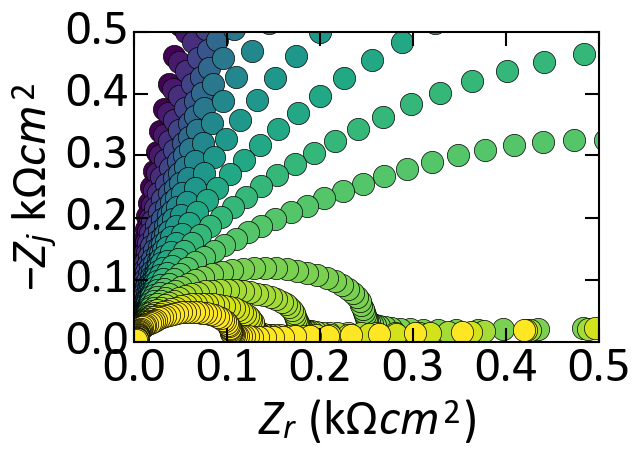

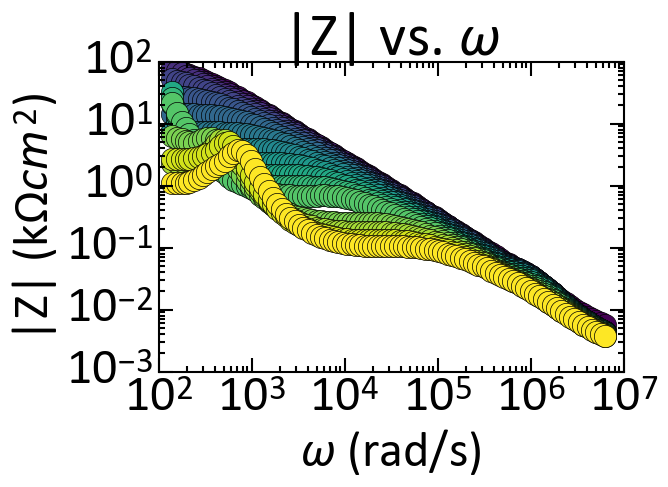

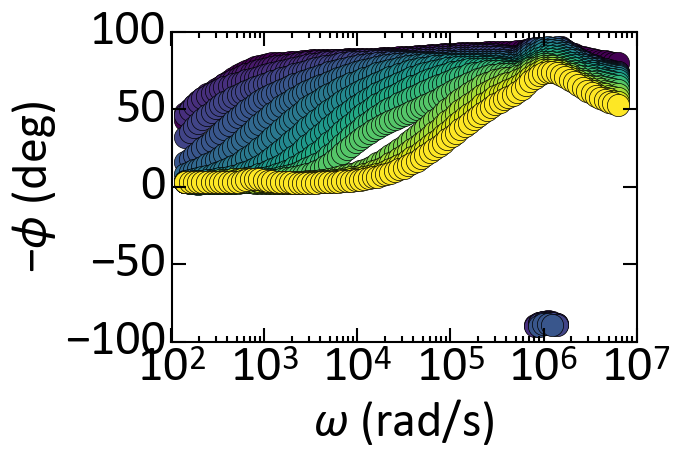

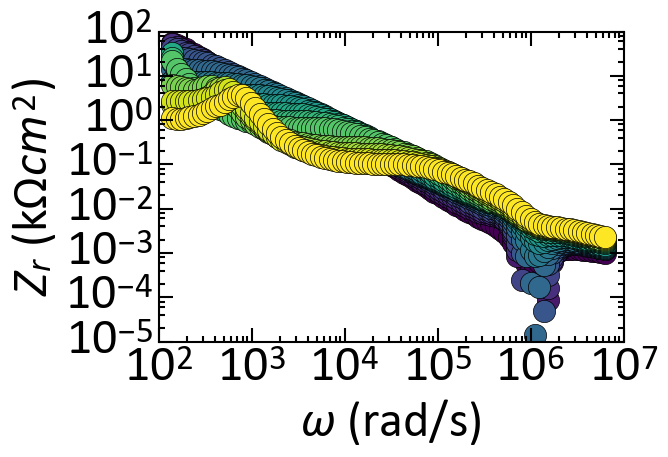

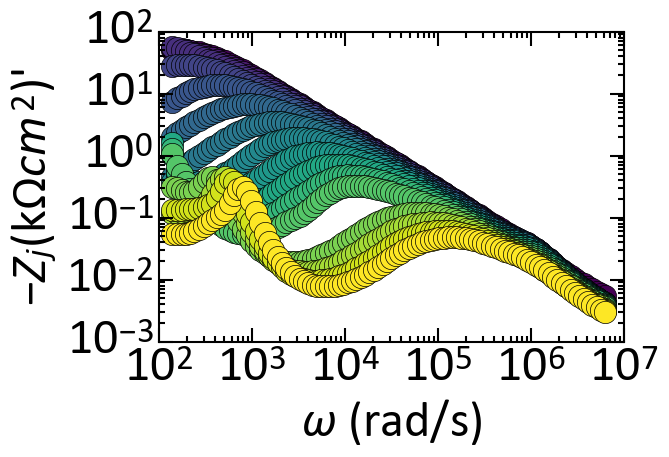

In [19]:
# Nyquist plots, |Z| and \phi vs \omega, Re(Z) vs \omega, and -Im(Z) vs \omega for all curves. 


# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(Zr(t)[:],-Zi(t)[:],'o',c = c)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,0.5, 0,0.5])
# plt.savefig('nyquist_all_zoom.png')

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
#     c = next(color)
    ax.plot(w(t)[:],np.sqrt(np.square(Zr(t)[:]) + np.square(Zi(t)[:])),'o',c = c) 
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-1,1e2]);
# plt.savefig('magZ_all.png')

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t)[:],-np.arctan((Zi(t)[:])/(Zr(t)[:]))*(180/np.pi),'o',c = c)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# plt.savefig('phase_all.png')

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t)[:],Zr(t)[:],'o', c = c)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,650]);
# plt.savefig('reZ_all.png')

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t)[:],abs(-Zi(t)[:]),'o', c = c)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,1]);
# plt.savefig('imZlog_all.png')


There's a lot of information here; so let's go through it plot by plot:

## 1) Nyquist plots ##
At the lowest temperatures (~indices 0-5), we clearly have no complete arcs indicating 1 time constant. The lack of an RC arc implies no single dominant kinetic process. At higher temperatures (~indices 6-end), nearly complete RC arcs appear, indicating the appearance of a dominant kinetic process. As temperature increases, the radius of the arc decreases dramatically, implying that the time constants of these kinetic processes decrease. This fits with physical intuition of the data analysis thus far--at higher temperatures, the resistance to recombination decreases leading to a smaller recombination lifetime $\tau_n$. 

## 2) |Z| vs. $\omega$ plots ##
I'm honestly not sure what to make of these. They all have roughly the same shape. It's interesting to note that |Z| appears to initially decrease with T as expected; however, at about the 4th or 5th curve, the impedance begins to rise again in a very regular fashion. What does this mean? Perhaps there is some new resistance activated after the 4th or 5th index? Is it a capacitance/CPE, or a real resistance? This may fit with the notion that after the 4th or 5th curve, a recombination process is activated and becomes more pronounced with T. 

## 3) $\phi$ vs. $\omega$ plots ##
These are cool looking. Basically, there are *no* pure capacitors with $\phi = 90^{0}$ at *any* temperature. The closest we get is at low temperature, where the $\phi$ appears to have 2 broad shoulders. As temperature increases, these shoulders evolve into broad peaks from indices ~5-12. At indices 11-12, the lower peak becomes very sharp. Above index 12, the lower frequency peak dissapears, and only the high frequency CPE-type phase angle is left.

According to Orazem, et al [(10.1149/1.2168377)](http://jes.ecsdl.org/content/153/4/B129.abstract) inflection points in $\phi$ indicate characteristic frequencies and time constants. At low temperatures, the broad shoulders have a very low frequency time constant, and almost indistinguishable high frequency time constant. This seems basically true up intil indices 11-12, where the appearance of a intermediate frequency peak in addition to the high frequency peak may indicate 2 relaxation processes. 

## 4) $Z_{r}$ vs. $\omega$ plots ##
The Orazem paper above states that the these plots contain the same information as the modulus plots in section 2. The high frequency part of the impedance should reveal the value of $R_{s}$, the series resistance. Interestingly, $R_{s}$ appears to increase with $T$. I'm not quite sure what to make of that (or even if this is an accurate way od determining $R_{s}$; the CPE analysis outlined in the kinetic.ipynb indicates it's not without problems). 

To answer the question posed in the plot of $|Z|$ vs. $\omega$, it seems like the increase in $|Z|$ results from an increase in Re(Z). 

## 5) $Im(Z)$ vs. $\omega$ plots ##
This is really what I was interested in looking at. Characteristic frequencies, and thus time constants, can be readily identified by looking at peaks in these plots. No correction for resistance is needed, as might be needed in the other plots. 

At the lowest temperatures (index < 5), we see no peaks, indicating no dominant kinetic processes. This matches exactly with that we inferred from the Nyquist plot. For indices >5, we start to see a small feature grow in at very low frequency, indicating a low frequency/long time constant kinetic process. As temperature increases, the position of this peak increases in frequency. At indices 11-12, we see a disjoint, and perhaps 2 *very* closely related peaks. For index >12, we see a discontinuous jump in the peak position and a merging of the 2 peaks into 1 (maybe).

So what is this telling me? I think it's saying that, basically, for all curves measured, there is 1 dominant kinetic process, giving rise to the arcs in the Nyquist plot. At curves 11-12, there may be a hint of a second process, but from curve 13 onward, it is again dominated by a single time consant. Note that these $\tau_{n}$ are clearly all CPEs and thus indicative of distributions of time constants. 

So let's take a look at a reduced range of the data. Maybe indices 5-16. I'm especially curious about what curevs 11-12 look like in the Nyquist plot, so lets take a look at this one first



C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


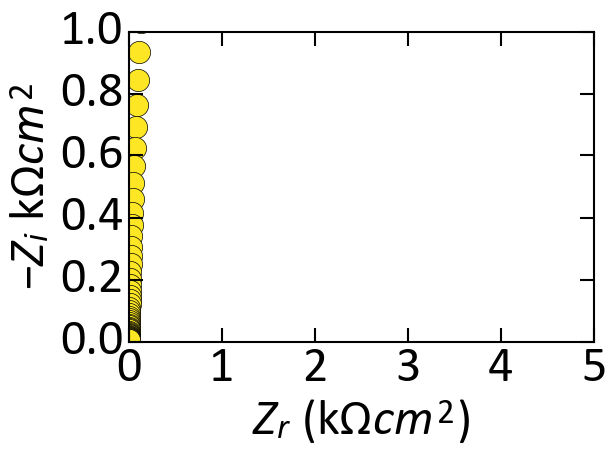

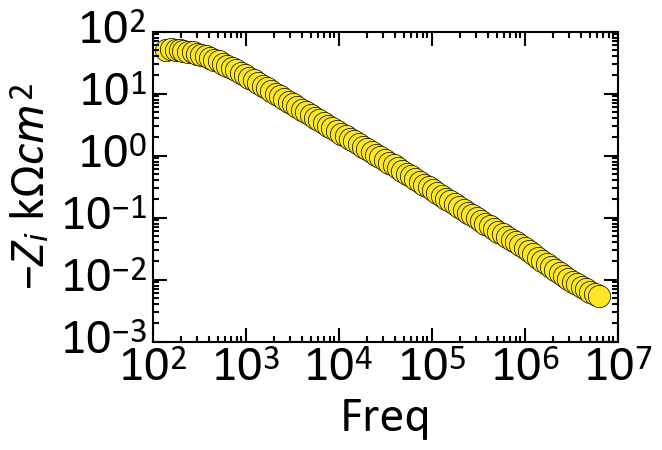

In [20]:
tstar = 0

# Nyquist plots
fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(Zr(tstar)[:],-Zi(tstar)[:],'o',c = c)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,5, 0,1])
# plt.savefig('nyquist_all_zoom.png')


fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(w(tstar)[:],abs(-Zi(tstar)[:]),'o', c = c)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.axis([0,5, 0,1])
# plt.savefig('nyquist_all_zoom.png')

Hm, ok, so the data is noisey, with perpahps a high frequency shoulder and a peak. But, it's really sort of hard to say. We could proabably fit 1 CPE to this and be OK; alternatively, we could try 2 and see what we get. It certainly looks like the slopes on either side of the most prominent peak are different.

For now, let's try fitting 1 CPE to this. My expectation is that we are observing 2 different activation processes: one at low T and one operating at high T. The transition between them is obviously not smooth. 


So what we want to do is start with whatever temperature we think is best (from above, it should be probably index 5 or so), and from there fit the data to a CPE. We can then loop through the fitting procedure used in the kinetc outline ipynb. To obtain pareter estimates for the $n-th$ fit, we'll use the parameters obtained for the $(n-1)-th$ fit.  

To prepare for the fit, we'll need to go through the Nyquist plots of the curves we wish to analyze and evaluate the range of data we want to include in the fit. Since I don't have a good way of automating that at the moment, it's probably best to tabulate the start and end points manually. 

In [21]:
print(tmax-3)

13


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


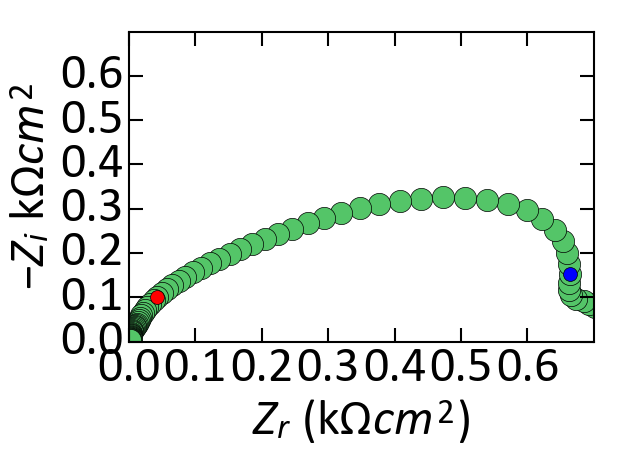

In [22]:
# clumsy way of ID-ing physically reasonable range of fit

bounds2 = np.zeros(13)
# print(np.size(bounds))

bounds1 = np.zeros(13)
# print(np.size(bounds))

Tt = 11

fig,ax = plt.subplots(1,1)
ax.plot(Zr(Tt)[:],-Zi(Tt)[:],'o', color = tuple(colSet[Tt]))
ax.plot(Zr(Tt)[65],-Zi(Tt)[65],'ro', markersize = 10)
ax.plot(Zr(Tt)[32],-Zi(Tt)[32],'bo', markersize = 10)

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,0.7, 0,0.7])
# plt.savefig('nyquist_all_zoom.png')

bounds1[0] = 0 
bounds1[1] = 0
bounds1[2] = 0
bounds1[3] = 0
bounds1[4] = 15
bounds1[5] = 20
bounds1[6] = 25
bounds1[7] = 31
bounds1[8] = 32
bounds1[9] = 38
bounds1[10] = 40
bounds1[11] = 42
bounds1[12] = 45

bounds2[0] = 70
bounds2[1] = 70
bounds2[2] = 70
bounds2[3] = 70
bounds2[4] = 70
bounds2[5] = 70
bounds2[6] = 70
bounds2[7] = 70
bounds2[8] = 72
bounds2[9] = 75
bounds2[10] = 80
bounds2[11] = 80
bounds2[12] = 78






What is this telling us?

There is a competition between space charge effects and  effects in forward bias. 

At high $\omega$, diffusion wins out. At low $\omega$, we have recombination. 

Similarly, at low $T$, recombination wins out. At higher $T$, diffusion starts to take over/is competitive with recombination.

The fact that we observe this in both reverse and forward bias likely means this is some interfacial state. 



43.4440436573
8.51964374767e-05


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


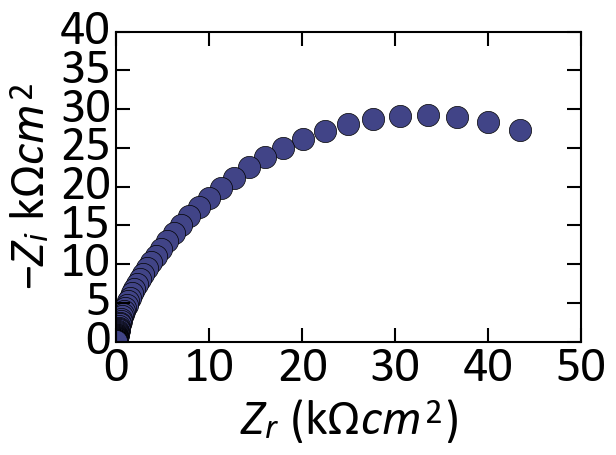

In [23]:
Tt = 3

fig,ax = plt.subplots(1,1)
ax.plot(Zr(Tt)[:],-Zi(Tt)[:],'o', color = tuple(colSet[Tt]))

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,50, 0,40])


# define a function that allows us to get the index of values read off the Nyquist plot so we know where to bound 
# the function in frequency
def ZrIdx(T,val):
    return max(np.where(Zr(T) <= val))[0]

zbound_1 = ZrIdx(Tt,45)
zbound_2 = ZrIdx(Tt,0.02)


# guesses for charge transfer resistance based on arc radii.
guessRct = abs(Zr(Tt)[zbound_2] - Zr(Tt)[zbound_1])

print(guessRct)

# guess values for omega 0
w0Idx = ZrIdx(Tt,25)
w0guess = w(Tt)[w0Idx]

# guess for Q based on peak freq of each arc and Rct guesses above. 
guessQ = 1/(guessRct*w0guess)


print(guessQ)



In [24]:
# define functions for the impedance of all circuit elements used in the analysis
# use a simple CPE. also include voigt element

# define a function for the impedance of a single RQ arc 
def arc(w,Rct,Q,alpha):
    return Rct/(1+((1j*w)**alpha)*Q*Rct)

# define a function for the impedace of a single RC arc
def voigt_el(w,Rct,tau):
    return Rct/(1+(1j*w*tau))

# define a function for the impedance of a series resistor
def seriesR(w,c):
    return c

from lmfit import Model

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:71: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(arc, prefix='a1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 65
    # data points      = 140
    # variables        = 4
    chi-square         = 7.90728443
    reduced chi-square = 0.05814180
    Akaike info crit   = -394.340121
    Bayesian info crit = -382.573551
[[Variables]]
    Rs_c:      2.3858e-07 +/- 0.01325613 (5556338.66%) (init = 1e-09)
    a1_Rct:    70.4119956 +/- 0.40695283 (0.58%) (init = 43.44404)
    a1_Q:      1.4556e-04 +/- 2.2648e-06 (1.56%) (init = 8.519644e-05)
    a1_alpha:  0.87896416 +/- 0.00263269 (0.30%) (init = 0.9)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1_Q, a1_alpha)   = -0.987
    C(a1_Rct, a1_Q)     =  0.868
    C(a1_Rct, a1_alpha) = -0.862
    C(Rs_c, a1_alpha)   =  0.487
    C(Rs_c, a1_Q)       = -0.410
    C(Rs_c, a1_Rct)     = -0.363



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


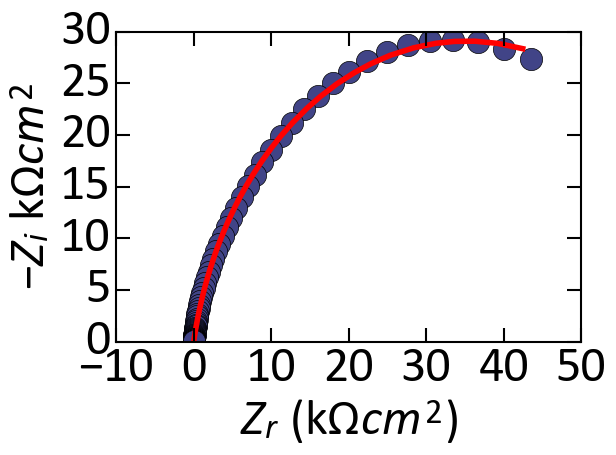

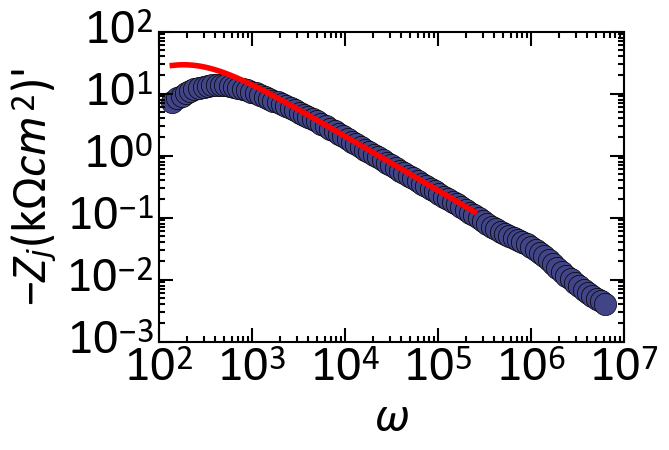

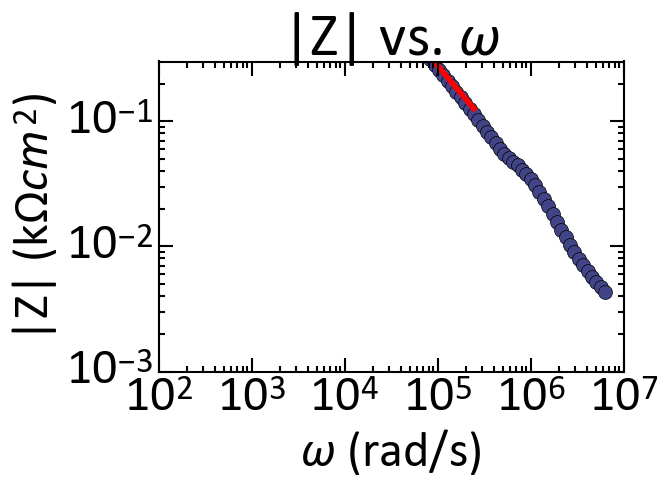

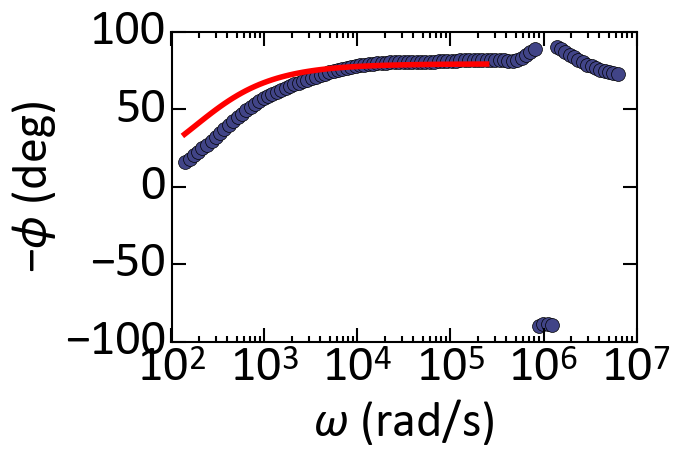

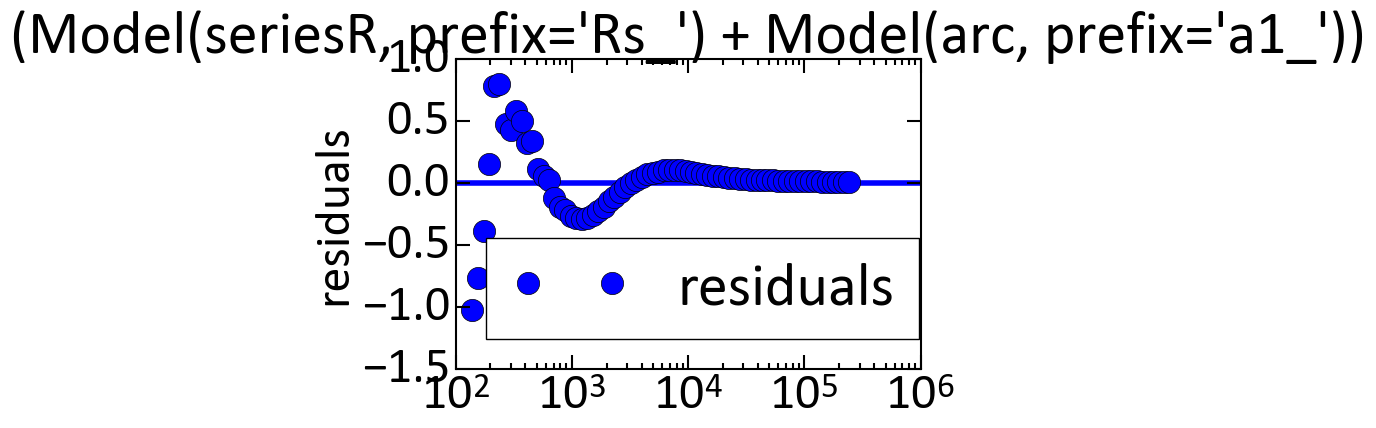

In [25]:
# define and run the models. 

# voigt model 
voigt1 = Model(voigt_el,prefix = 'v1_')
voigt2 = Model(voigt_el,prefix = 'v2_')
voigt3 = Model(voigt_el,prefix ='v3_')

# CPE model
arc1 = Model(arc,prefix ='a1_')

# series resistor
Rs = Model(seriesR,prefix = 'Rs_')

# define the aggregate voigt model
vModel = Rs + voigt1 + voigt2 + voigt3 

# define the aggregate CPE model
cModel = Rs + arc1


# add parameters with guesses at lowest temperature. 
params = lmf.Parameters()  

params.add('Rs_c',value =  1e-9, min = 0, max = 10)
params.add('a1_Rct',value = abs(guessRct), min = 0, max = 100)
params.add('a1_Q',value = abs(guessQ), min = 0, max = 1e-3)
params.add('a1_alpha',value = 0.9 , min = 0, max = 1)


# make the data complex and enter weights
data = Zr(3)[bounds1[0]:bounds2[0]]+1j*Zi(3)[bounds1[0]:bounds2[0]]
weights = 1/(0.05*Zmag(3)[bounds1[0]:bounds2[0]])


#try the fit
# fit_result = cModel.fit(data, w = w(Tt),params = params, weights = weights)
fit_result = cModel.fit(data, w = w(3)[bounds1[0]:bounds2[0]],params = params)
print(fit_result.fit_report())

# store the Rs fit value to check the phase angle plot
# RsFit = fit_result.params['Rs_c'].value

# make arrays that store the real and imaginary parts, magnitude, and phase (both raw and adjusted)
fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)
phiFit = -np.arctan(imFit/reFit)*(180/np.pi)
# phiFitAdj = -np.arctan(imFit/(reFit - RsFit))*(180/np.pi)

# Nyquist with fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr(3),-Zi(3),'o', color = tuple(colSet[3]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
# ax.set_aspect('equal')

# Z_i with fit
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi(4)),'o', color = tuple(colSet[3]))
ax.plot(w(3)[bounds1[0]:bounds2[0]],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(3),Zmag(3),'o',c = tuple(colSet[3]), markersize = 10) 
ax.plot(w(3)[bounds1[0]:bounds2[0]],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(3),phi(4),'o',c = tuple(colSet[3]), markersize = 10) 
ax.plot(w(3)[bounds1[0]:bounds2[0]],phiFit, color = 'r')
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# # \phi_{adj} vs. \omega
# fig, ax = plt.subplots(1,1)
# ax.plot(w(11),phi600adj(11),'o',c = c, markersize = 10)
# ax.plot(w(11)[bounds6a[11]:bounds6b[11]],phiFitAdj, color = 'r')
# # ax.set_aspect('equal')
# ax.set_xlabel("$\omega$ (rad/s)")
# ax.set_ylabel("$-\phi$ (deg)")
# ax.set_xscale("log") 
# # ax.set_yscale("log") 
# # ax.set_title("$\phi_{adj}$ vs. $\omega$")
# #ax.set_xlim([0,1]);
# #ax.set_ylim([0,1]);
# # figName = '\\phaseAdj_400mV_all.png'
# # plt.savefig(figDir + figName,dpi = 300)

fig,ax = plt.subplots(1,1)
ax.set_xscale('log')
fit_result.plot_residuals(ax=ax)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


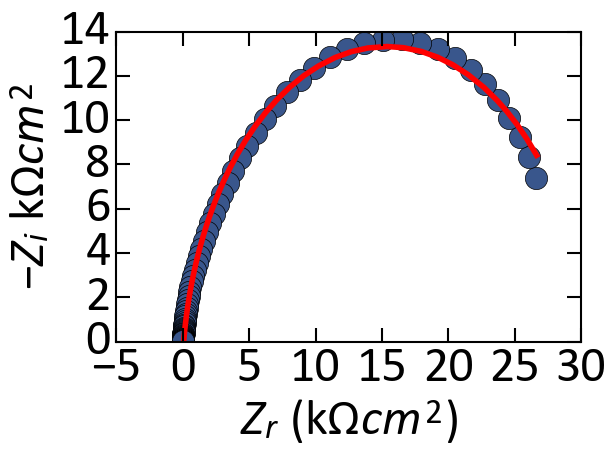

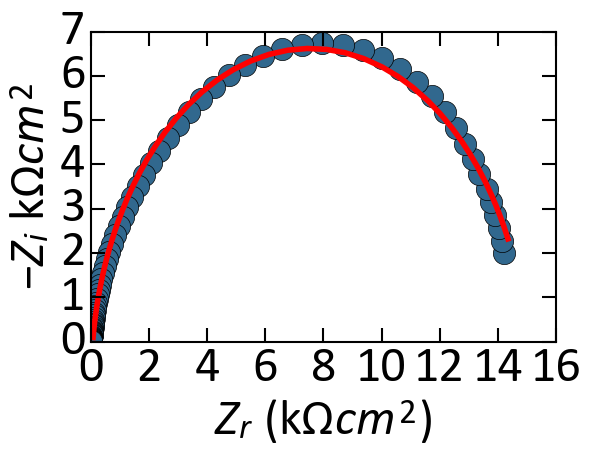

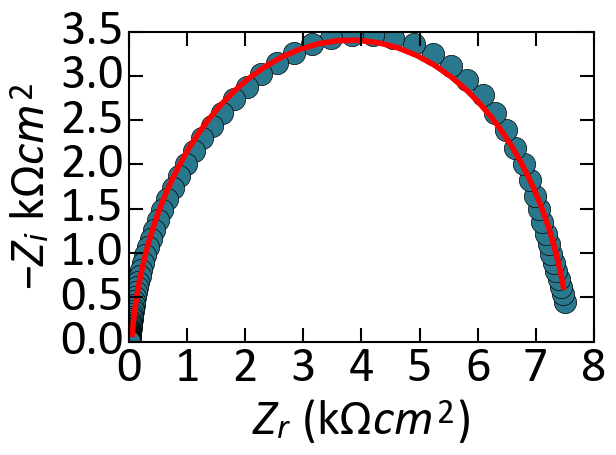

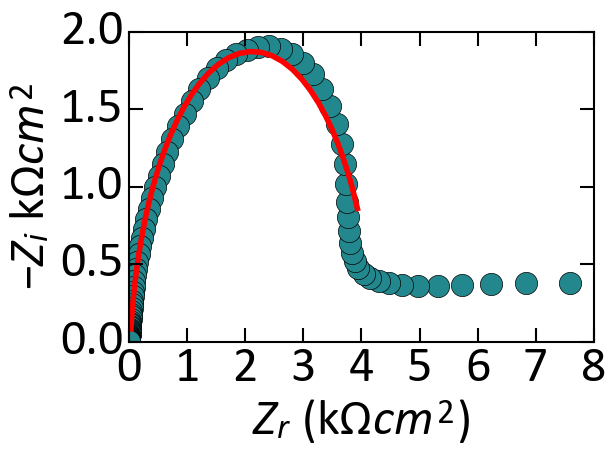

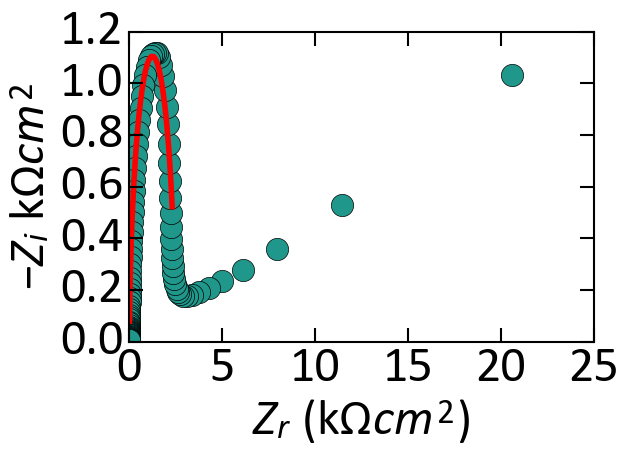

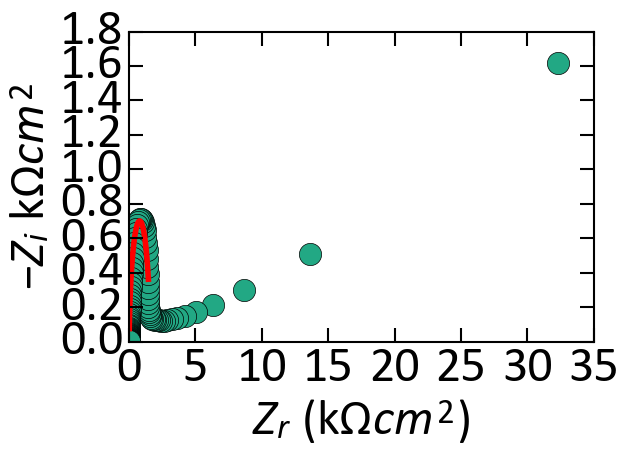

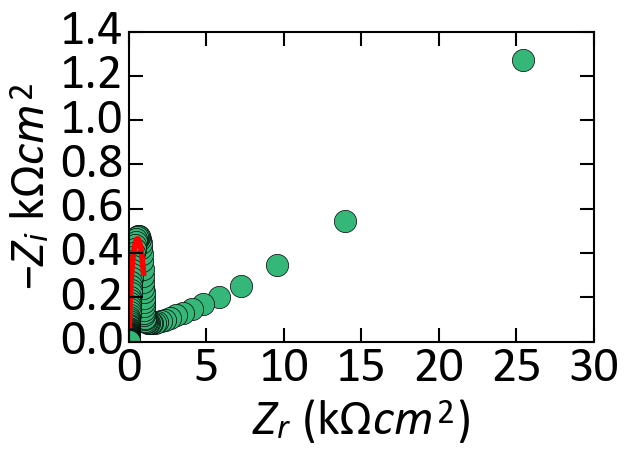

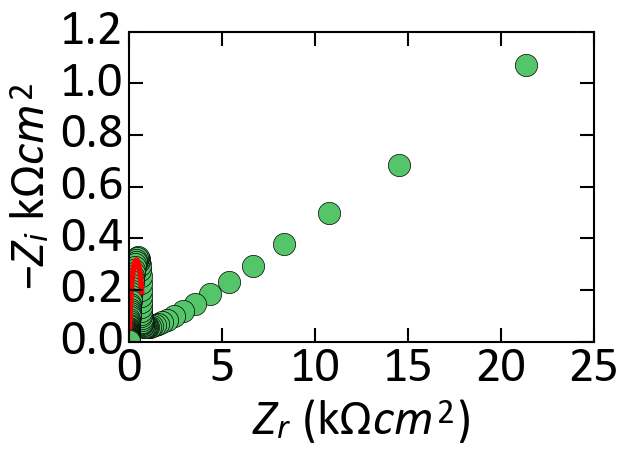

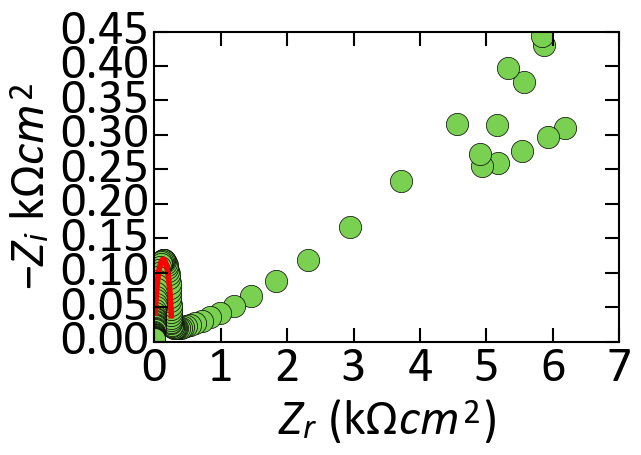

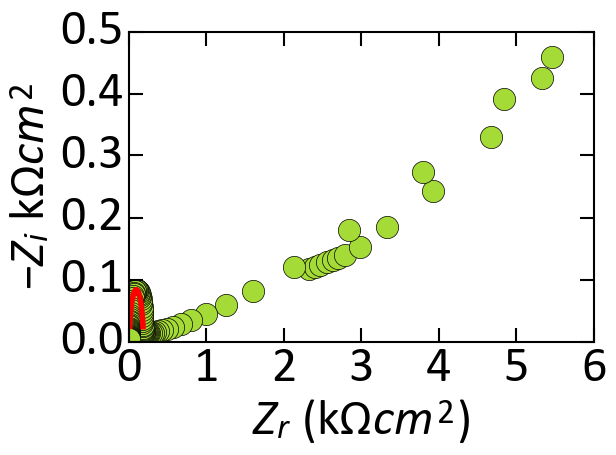

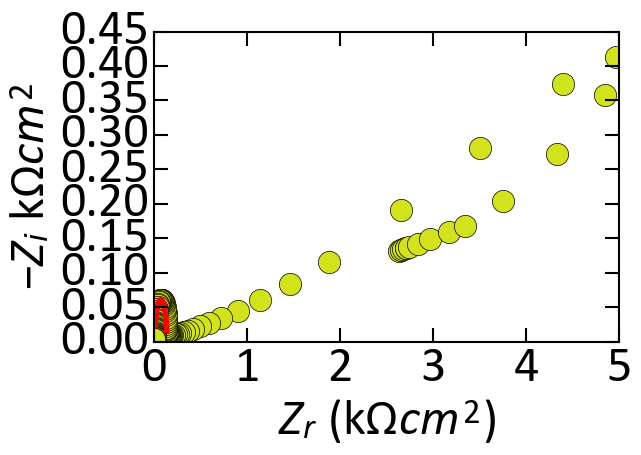

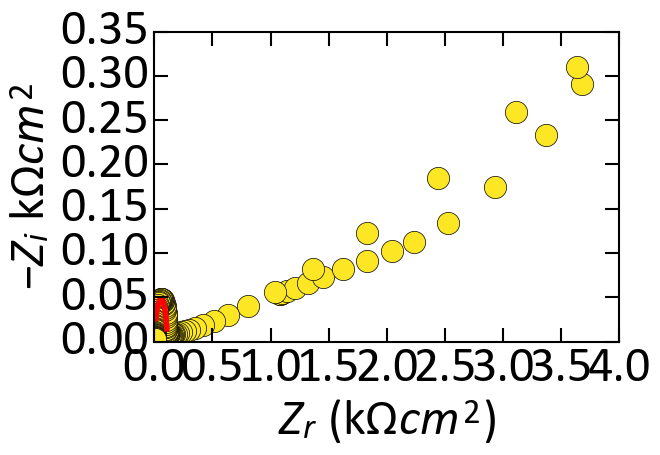

In [26]:
#ok with this done let's start fitting in a loop. 

# empty arrays for storing fit parameters
RsFits = []
RctFits = []
QFits = []
alphaFits =[]
fitResults = []

# store initial fit values
RsFits.append(fit_result.params['Rs_c'].value)
RctFits.append(fit_result.params['a1_Rct'].value)
QFits.append(fit_result.params['a1_Q'].value)
alphaFits.append(fit_result.params['a1_alpha'].value)
fitResults.append(fit_result)

for t in range(4,tmax):
    params = lmf.Parameters() 
    params.add('Rs_c',value = RsFits[t-4], min = 0, max = 5)
    params.add('a1_Rct',value = RctFits[t-4], min = 0, max = 100)
    params.add('a1_Q',value = QFits[t-4], min = 0, max = 1e-3)
    params.add('a1_alpha',value = alphaFits[t-4] , min = 0, max = 1)
    
    #data and weights
    data = Zr(t)[bounds1[t-3]:bounds2[t-3]]+1j*Zi(t)[bounds1[t-3]:bounds2[t-3]]
    weights = 1/(.05*Zmag(t)[bounds1[t-3]:bounds2[t-3]])
    
    #run the fit
    fit_result = cModel.fit(data, w = w(t)[bounds1[t-3]:bounds2[t-3]],params = params)
         
    #store parameters and fits
    RsFits.append(fit_result.params['Rs_c'].value)
    RctFits.append(fit_result.params['a1_Rct'].value)
    QFits.append(fit_result.params['a1_Q'].value)
    alphaFits.append(fit_result.params['a1_alpha'].value)
    fitResults.append(fit_result)

    # plot the resulting fit
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr(t),-Zi(t),'o', color = tuple(colSet[t]))
    ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
    



In [27]:
print(alphaFits)
print(len(alphaFits))

[0.87896415848239084, 0.91297332536899567, 0.92207902348033, 0.93471494780169717, 0.92624994316121767, 0.92245404330355951, 0.9202053874884597, 0.90085758359427048, 0.87958344860890714, 0.94455289387887276, 0.93806133207155229, 0.93544221426530982, 0.93320547249628871]
13


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


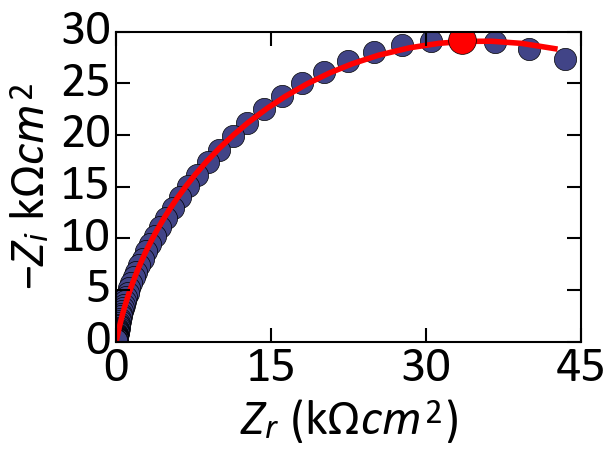

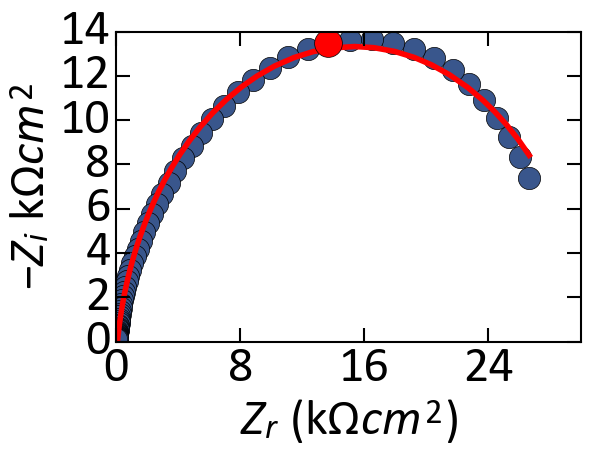

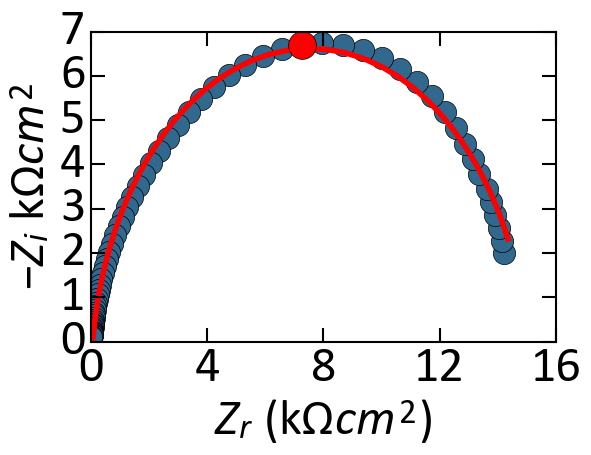

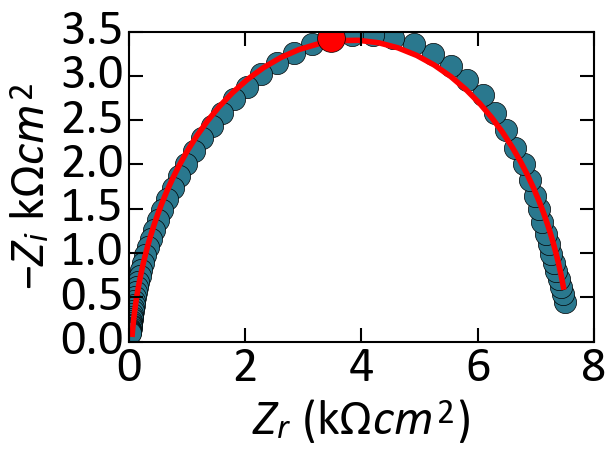

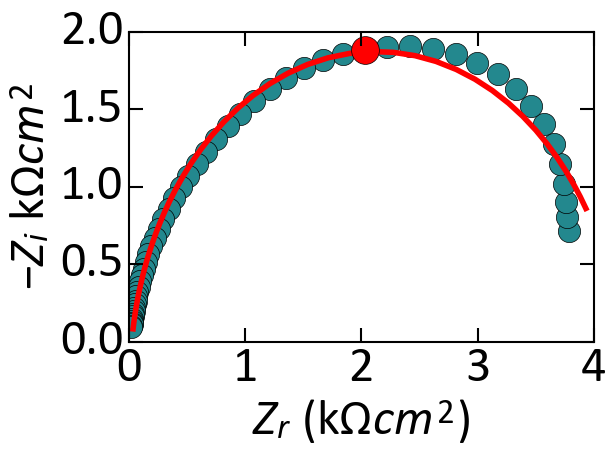

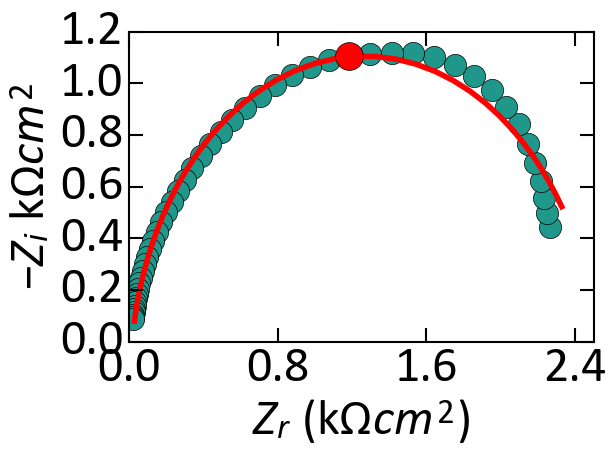

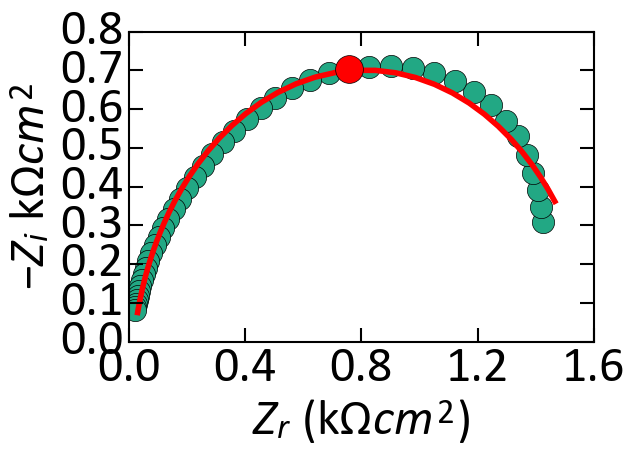

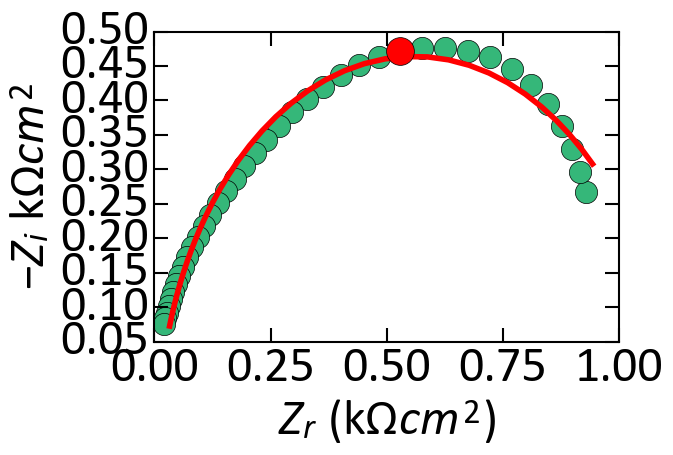

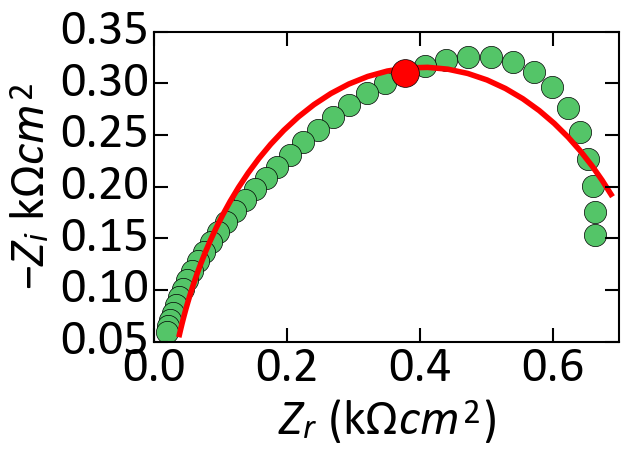

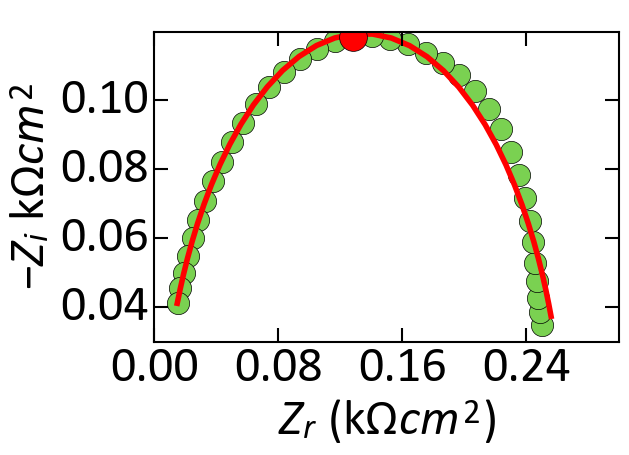

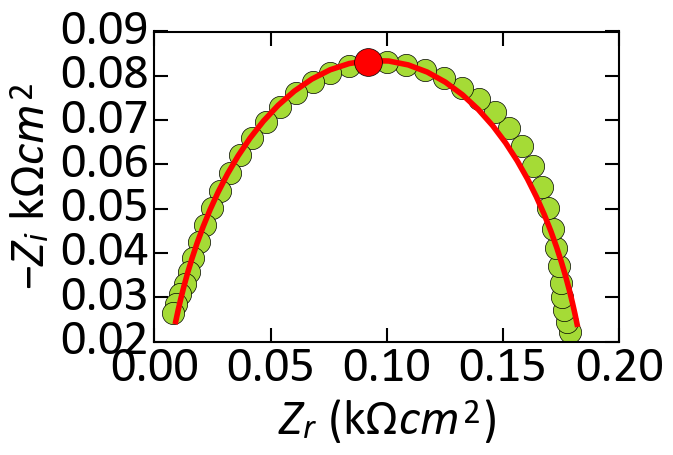

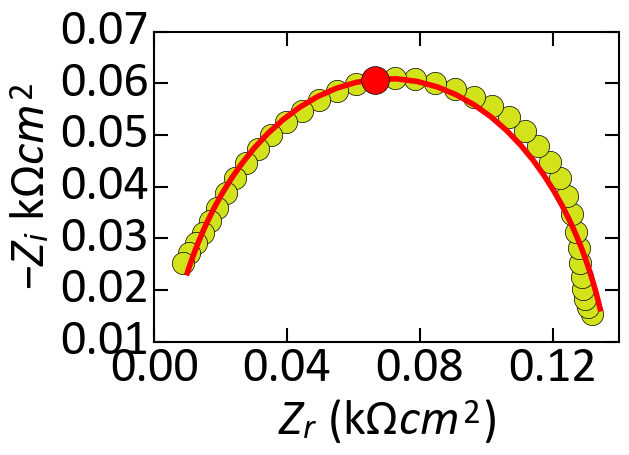

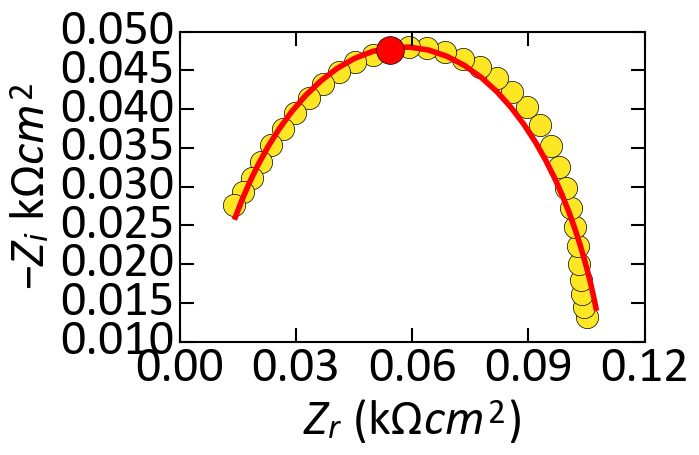

In [28]:
# first make all the fit parameters np arrays to keep track of the data types
alphaFit = np.asarray(alphaFits)
QFit = np.asarray(QFits)
RsFit = np.asarray(RsFits)
RctFit = np.asarray(RctFits)

# now do the calculation. obtain both tau and the index of w0
tau = np.zeros(tmax-3)
wt0 = np.zeros(tmax-3)
for t in range(3,tmax):
    tau[t-3] = [QFit[t-3]*RctFit[t-3]]**(1/alphaFit[t-3])
    wt0[t-3] = np.argmax(w(t) > (1/tau[t-3]))
    
    fig,ax = plt.subplots(1,1)
    ax.plot(Zr(t)[bounds1[t-3]:bounds2[t-3]],-Zi(t)[bounds1[t-3]:bounds2[t-3]],'o', color = tuple(colSet[t]))
    ax.plot(np.real(fitResults[t-3].best_fit),-np.imag(fitResults[t-3].best_fit),color = 'r')
    
    ax.plot(Zr(t)[wt0[t-3]],-Zi(t)[wt0[t-3]],'ro', markersize = 20)
    
    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
    ax.xaxis.set_major_locator(MaxNLocator(4))
#     figName = '\\Zfit_'+ np.array2string(T[t+Tt].astype(int)) + '.png'
#     plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')
    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


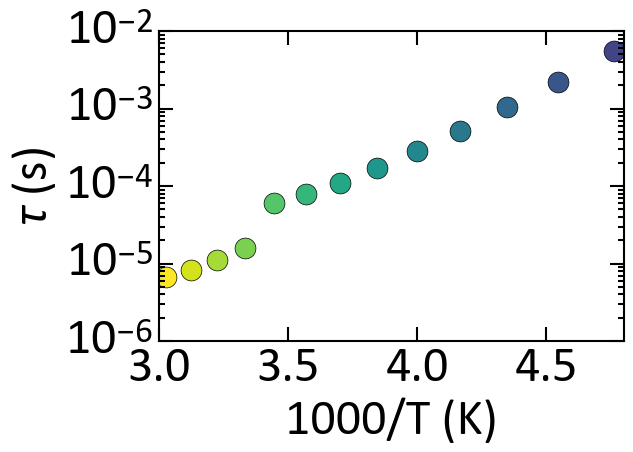

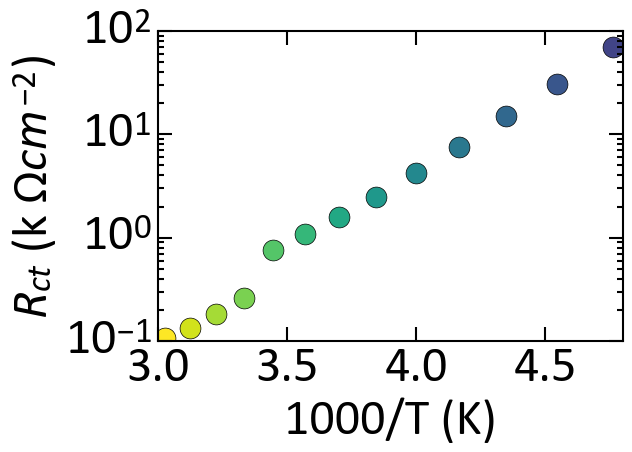

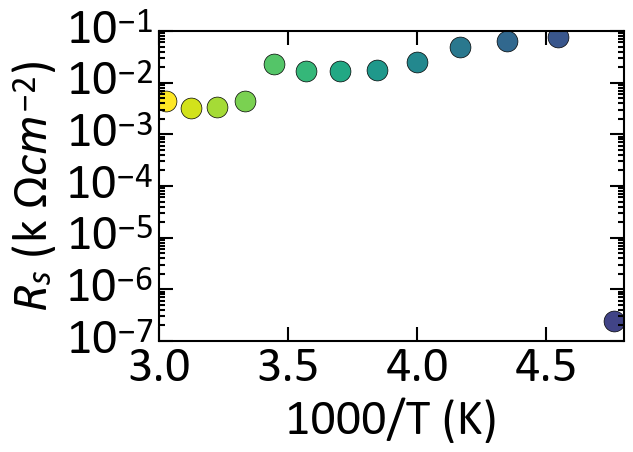

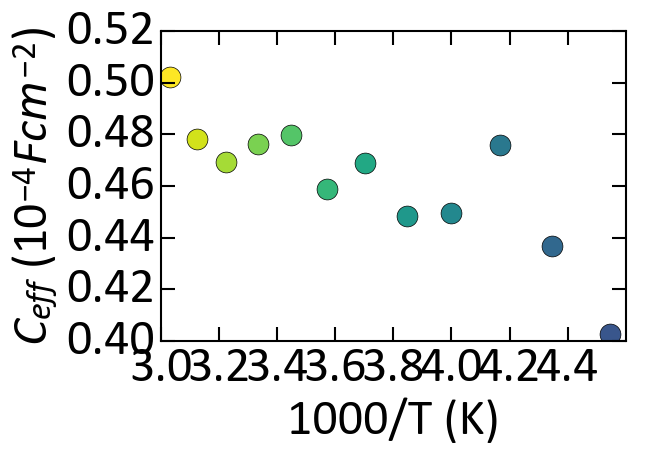

In [29]:
fig,ax = plt.subplots(1,1)
for t in range(3,tmax):
    ax.plot(1e3/T[t],tau[t-3],'o',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$\\tau$ (s)")
ax.set_yscale('log')
#     plt.savefig('nyquistTau.png')

fig,ax = plt.subplots(1,1)
for t in range(3,tmax):
    ax.plot(1e3/T[t],RctFits[t-3],'o',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')
#     plt.savefig('nyquistTau.png')

fig,ax = plt.subplots(1,1)
for t in range(3,tmax):
    ax.plot(1e3/T[t],RsFits[t-3],'o',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$R_{s}$ (k $\Omega cm^{-2}$)")
ax.set_yscale('log')

# also calculate the effective capacitance (according to Brug, et. al.) and see if this matches with our intuition of what's happening
Ceff = np.zeros(13)
for t in range(3,tmax):
    Ceff[t-3] = [QFit[t-3]*((1/RsFit[t-3]) + (1/RctFit[t-3]))**(alphaFit[t-3]-1)]**(1/alphaFit[t-3])

fig,ax = plt.subplots(1,1)
for t in range(4,tmax):
    ax.plot(1e3/T[t],Ceff[t-3]*1e4,'o',color=tuple(colSet[t]),markersize = 15)
ax.set_xlabel("1000/T (K)")
ax.set_ylabel("$C_{eff}$ ($10^{-4}F cm^{-2}$)")
# ax.set_yscale('log')

In [30]:
# T[11]

# Tc2 = 12

# print(T[3:Tc2])
# print(T[Tc2:])

# print(len(T[3:Tc2]))
# print(len(T[Tc2:]))

# tauC = 9
# print(tau[:tauC])
# print(tau[tauC:])

# print(len(tau[:tauC]))
# print(len(tau[tauC:]))

# print(len(yt1))
# print(len(xt1))


# print(len(tau[:tauC]))

In [31]:
# print(stdErr_tau1*12)

Fit over 2 regimes: one from T = 210 - 290K, one from T = 300 - 300 K 

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


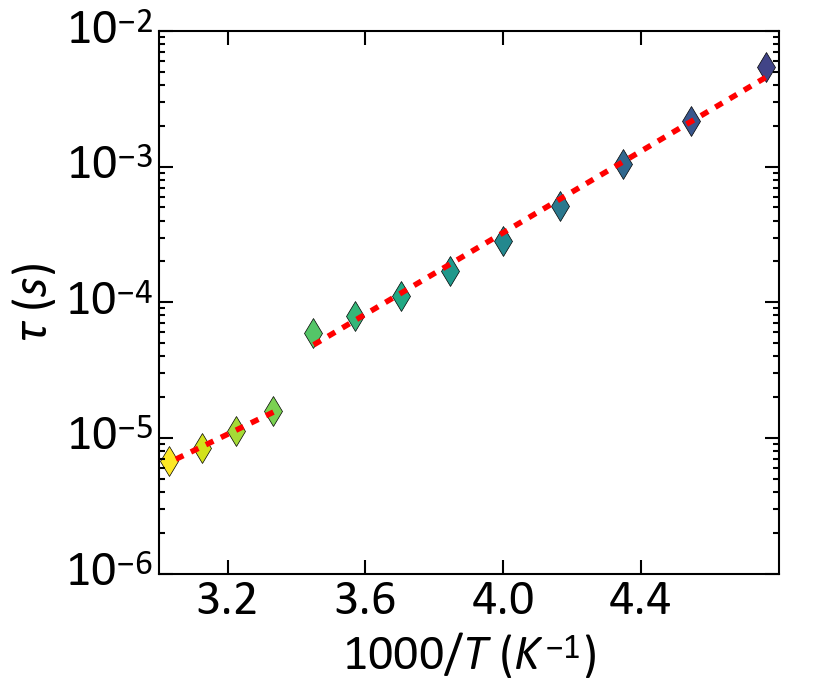

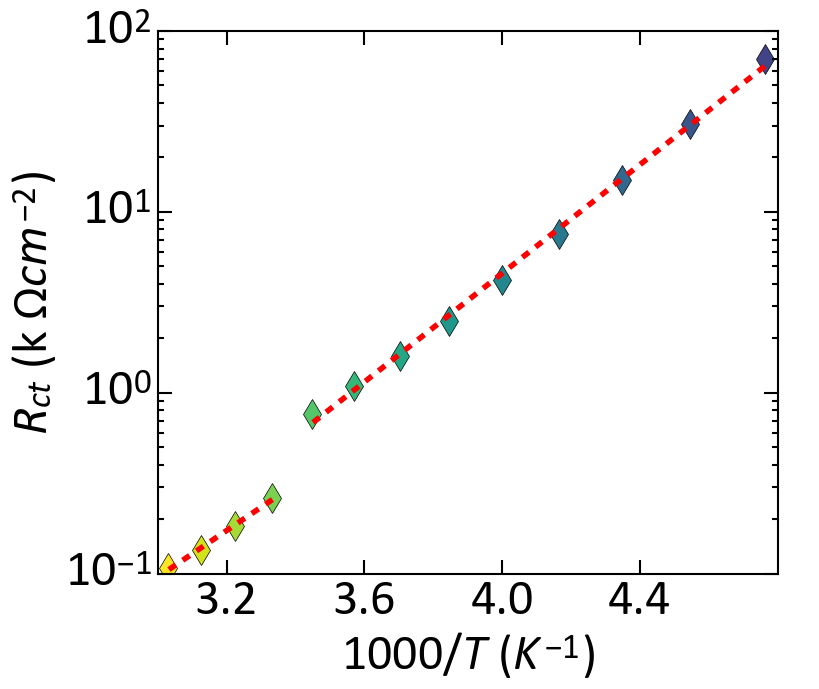

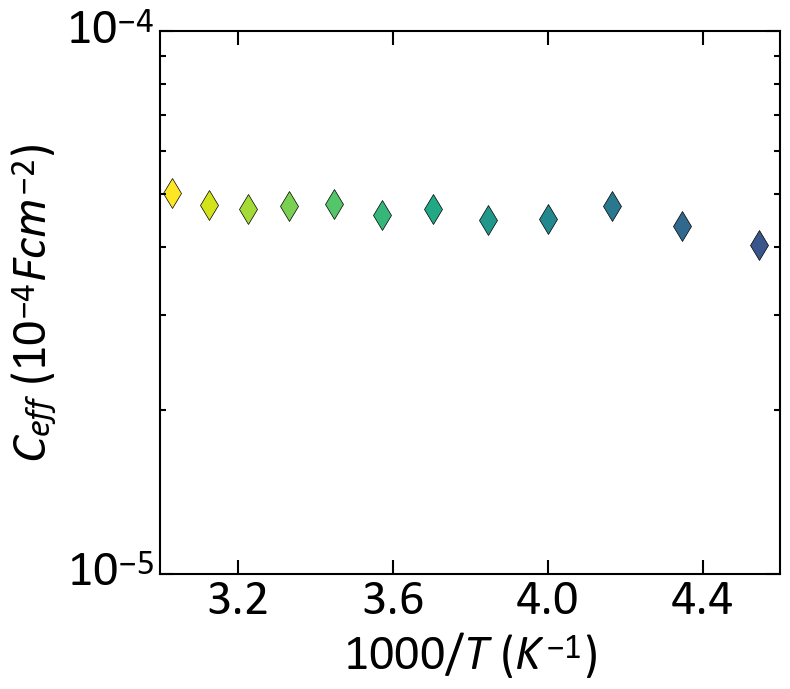

In [32]:
Tt = 3

# critical T to end first fit and begin second fit
Tc = 12 

# critical tau to end first fit and begin second fit
tauC = 9

# fit to tau, regime 1 with error estimates
xt1 = np.vstack( [1e3/T[3:Tc], np.ones(len(T[3:Tc]))] ).T
yt1 = np.log(tau[:tauC])

mt1,ct1 = np.linalg.lstsq(xt1,yt1)[0]
Etau1 = np.abs((kB*mt1)*1e3)
tauLine1 =  np.exp(mt1*(1e3/T[3:Tc])) * np.exp(ct1)
tauCoeff1 = np.array([mt1, ct1])
# error estimates
dLen_tau1 = len(yt1)
tauCoeffLen1 = len(tauCoeff1)
rmse_tau1 = np.sum((yt1 - np.dot(xt1,tauCoeff1))**2)/(dLen_tau1-tauCoeffLen1)
covMat_tau1 = rmse_tau1*np.linalg.inv(np.dot(xt1.T,xt1))
stdErr_tau1 = np.sqrt(np.diagonal(covMat_tau1))
EtauErr1 = stdErr_tau1[0]*Etau1

# fit to tau, regime 2 with error estimates
xt2 = np.vstack( [1e3/T[Tc:], np.ones(len(T[Tc:]))] ).T
yt2 = np.log(tau[tauC:])

mt2,ct2 = np.linalg.lstsq(xt2,yt2)[0]
Etau2 = np.abs((kB*mt2)*1e3)
tauLine2 =  np.exp(mt2*(1e3/T[Tc:])) * np.exp(ct2)
tauCoeff2 = np.array([mt2, ct2])
# error estimates
dLen_tau2 = len(yt2)
tauCoeffLen2 = len(tauCoeff2)
rmse_tau2 = np.sum((yt2 - np.dot(xt2,tauCoeff2))**2)/(dLen_tau2-tauCoeffLen2)
covMat_tau2 = rmse_tau2*np.linalg.inv(np.dot(xt2.T,xt2))
stdErr_tau2 = np.sqrt(np.diagonal(covMat_tau2))
EtauErr2 = stdErr_tau2[0]*Etau2

# fit to capacitance with error estimates
xC = np.vstack( [1e3/T[3:], np.ones(len(T[3:]))] ).T
yC = np.log(Ceff[:])

mC,cC = np.linalg.lstsq(xC,yC)[0]
Ecap = np.abs((kB*mC)*1e3)
cLine =  np.exp(mC*(1e3/T[Tt:])) * np.exp(cC)
cCoeff = np.array([mC, cC])
# error estimates
dLen_c = len(yC)
capCoeffLen = len(cCoeff)
rmse_cap = np.sum((yC - np.dot(xC,cCoeff))**2)/(dLen_c-capCoeffLen)
covMat_cap = rmse_cap*np.linalg.inv(np.dot(xC.T,xC))
stdErr_cap = np.sqrt(np.diagonal(covMat_cap))
EcapErr = stdErr_cap[1]*Ecap

# fit to resistance in the first regime with error estimates
xR1 = np.vstack( [1e3/T[Tt:Tc], np.ones(len(T[Tt:Tc]))] ).T
yR1 = np.log(RctFits[:tauC])

mR1,cR1 = np.linalg.lstsq(xR1,yR1)[0]
Er1 = np.abs((kB*mR1)*1e3)
rLine1 =  np.exp(mR1*(1e3/T[Tt:Tc])) * np.exp(cR1)
rCoeff1 = np.array([mR1, cR1])
# error estimates
dLen_r1 = len(yR1)
rCoeffLen1 = len(rCoeff1)
rmse_r1 = np.sum((yR1 - np.dot(xR1,rCoeff1))**2)/(dLen_r1-rCoeffLen1)
covMat_r1 = rmse_r1*np.linalg.inv(np.dot(xR1.T,xR1))
stdErr_r1 = np.sqrt(np.diagonal(covMat_r1))
ErErr1 = stdErr_r1[0]*Er1

# fit to resistance in the second regime with error estimates
xR2 = np.vstack( [1e3/T[Tc:], np.ones(len(T[Tc:]))] ).T
yR2 = np.log(RctFits[tauC:])

mR2,cR2 = np.linalg.lstsq(xR2,yR2)[0]
Er2 = np.abs((kB*mR2)*1e3)
rLine2 =  np.exp(mR2*(1e3/T[Tc:])) * np.exp(cR2)
rCoeff2 = np.array([mR2, cR2])
# error estimates
dLen_r2 = len(yR2)
rCoeffLen2 = len(rCoeff2)
rmse_r2 = np.sum((yR2 - np.dot(xR2,rCoeff2))**2)/(dLen_r1-rCoeffLen1)
covMat_r2 = rmse_r2*np.linalg.inv(np.dot(xR2.T,xR2))
stdErr_r2 = np.sqrt(np.diagonal(covMat_r2))
ErErr2 = stdErr_r2[0]*Er2


# plot tau data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax):
    ax.plot(1e3/T[t],tau[t-3],'d',color=tuple(colSet[t]),markersize = 15)

ax.plot(1e3/T[Tt:Tc],tauLine1[:],color = 'r',linestyle='dashed' )
ax.plot(1e3/T[Tc:],tauLine2[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\tau$ ($s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\tau_arrheniusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# plot Rct data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax):
    ax.plot(1e3/T[t],RctFits[t-3],'d',color=tuple(colSet[t]),markersize = 15)

ax.plot(1e3/T[Tt:Tc],rLine1[:],color = 'r',linestyle='dashed' )
ax.plot(1e3/T[Tc:],rLine2[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\R_arrhenhiusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# plot C data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(4,tmax):
    ax.plot(1e3/T[t],Ceff[t-3],'d',color=tuple(colSet[t]),markersize = 15)

# ax.plot(1e3/T[Tt:],cLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$C_{eff}$ ($10^{-4}F cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\C_arrhenhiusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


In [33]:
print('Activation of tau at low T: {}'.format(Etau1) + ' +\- {}'.format(EtauErr1))
print('Activation of tau at high T: {}'.format(Etau2) + ' +\- {}'.format(EtauErr2))
print('Activation of R at low T: {}'.format(Er1) + ' +\- {}'.format(ErErr1))
print('Activation of R at high T: {}'.format(Er2) + ' +\- {}'.format(ErErr2))
print('Activation of C: {}'.format(Ecap) + ' +\- {}'.format(EcapErr))

Activation of tau at low T: 0.2981546002951244 +\- 0.03264062498180449
Activation of tau at high T: 0.24337653337434917 +\- 0.03515864727728051
Activation of R at low T: 0.2981152556735255 +\- 0.01890855244766148
Activation of R at high T: 0.25564208575169156 +\- 0.016700916935498005
Activation of C: 0.05514160191497202 +\- 0.05538197986896157


In [34]:
tau[3]
# QFit[3]
# alphaFit[3]
# RctFit[3]
# RsFit[3]

0.00051083141567435605

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


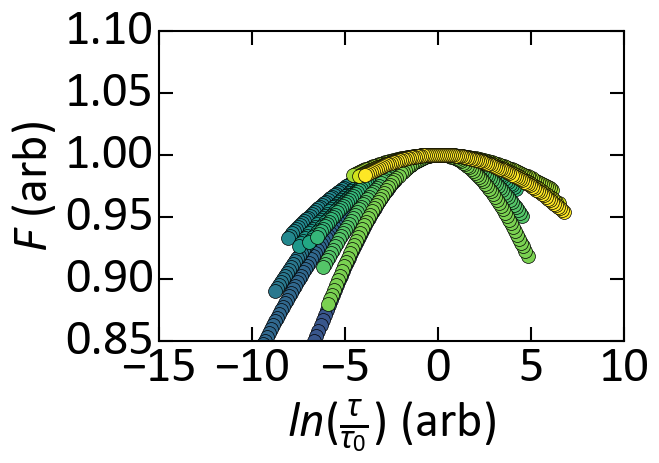

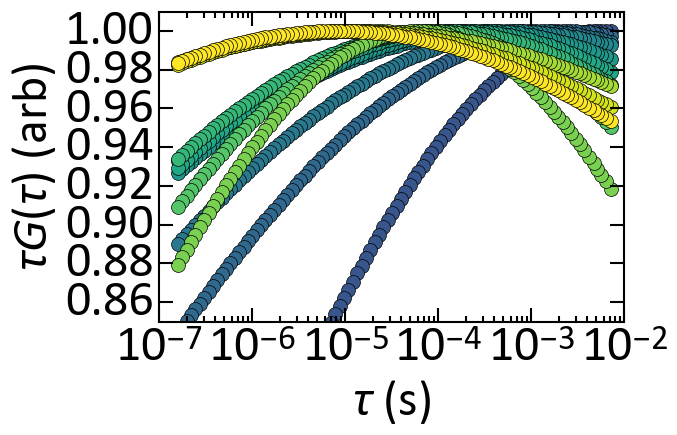

In [35]:
# calculate and plot the distribution of lifetimes G(\tau)

tauArray = 1/w(1)[:]
G = np.zeros((w(1).shape[0],13))
Gnorm = np.zeros((w(1).shape[0],13))
sArray = np.zeros((w(1).shape[0],13))
F = np.zeros((w(1).shape[0],13))
Fnorm = np.zeros((w(1).shape[0],13))
tG = np.zeros((w(1).shape[0],13))
tGnorm = np.zeros((w(1).shape[0],13))

# calculate the distribution for 200 different lifetimes that span from 1 order of magnitude above the largest \tau and 1 
# order of magnitude smaller than the lowest \tau
for t in range(0,12):
    G[:,t] = (1/(2*np.pi*tauArray[:]))*((np.sin(np.pi*alphaFit[t]))/(np.cosh((1-alphaFit[t])*np.log(tauArray[:]/tau[t])) - np.cos(alphaFit[t]*np.pi))) 
    Gnorm[:,t] = G[:,t]/np.amax(G[:,t])
    
    sArray[:,t] = np.log(tauArray[:]/tau[t])
    
    F[:,t] = ((np.sin(np.pi*alphaFit[t]))/(np.cosh((1-alphaFit[t])*np.log(tauArray[:]/tau[t])) - np.cos(alphaFit[t]*np.pi)))
    Fnorm[:,t] = F[:,t]/np.amax(F[:,t])   
    
    tG[:,t] = tauArray*G[:,t]
    tGnorm[:,t] = tG[:,t]/np.amax(tG[:,t])
    
    
# first plot the F function, which is a **normal** distribution of ln((\tau)/(\tau_0))    
fig,ax = plt.subplots(1,1)
for t in range(0,12):
    ax.plot(sArray[:,t],Fnorm[:,t],'o', markersize = 10,color = tuple(colSet[t+4]))
#     ax.plot(tauArray[:],Gnorm[:,t],'o', markersize = 10,color = tuple(colSet[t+offSet]))
ax.set_xlabel("$ln(\\frac{\\tau}{\\tau_{0}}$) (arb)")
ax.set_ylabel("$F$ (arb)")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_ylim([0.85,1.1]);
# ax.set_xlim([-1,1e-3]);
# plt.savefig('F_distribution.png')


# now plot the G function, which is a power law function of \tau
fig,ax = plt.subplots(1,1)
for t in range(0,12):
    ax.plot(tauArray[:],tGnorm[:,t],'o', markersize = 10,color = tuple(colSet[t+4]))
ax.set_xlabel("$\\tau$ (s)")
ax.set_ylabel("$\\tau G(\\tau)$ (arb)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_ylim([0.85,1.01]);
# ax.set_xlim([-1,1e-3]);
# plt.savefig('G_distribution.png')

In [36]:
np.where(T==240)

(array([6], dtype=int64),)

## Figure Plots##

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:126: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


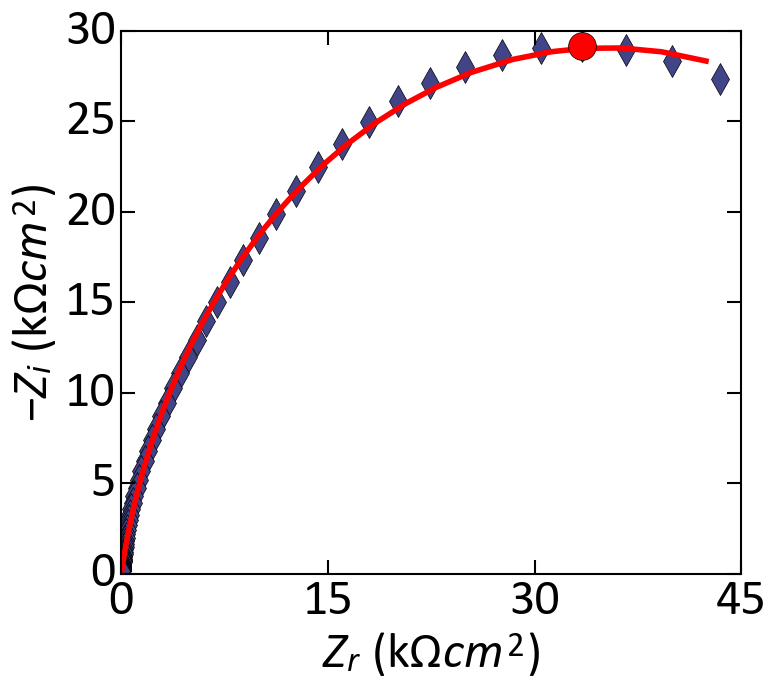

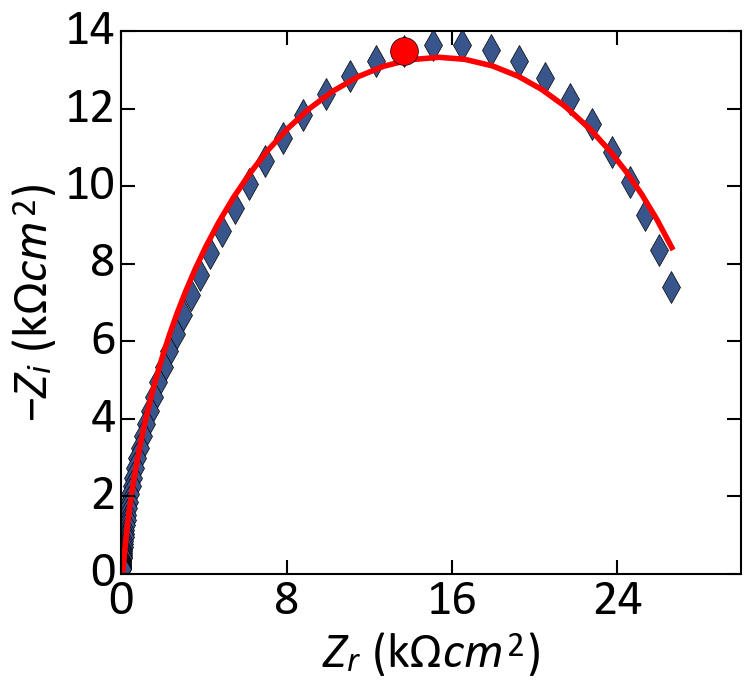

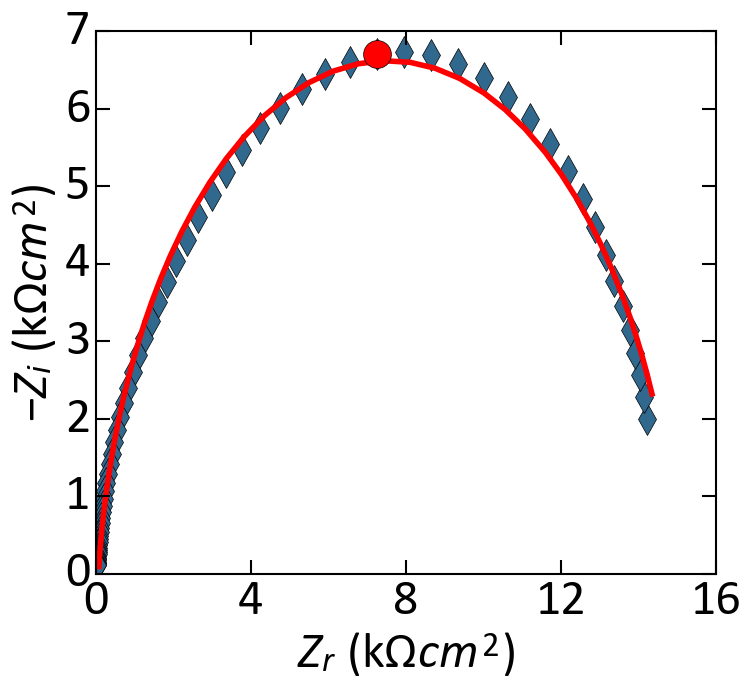

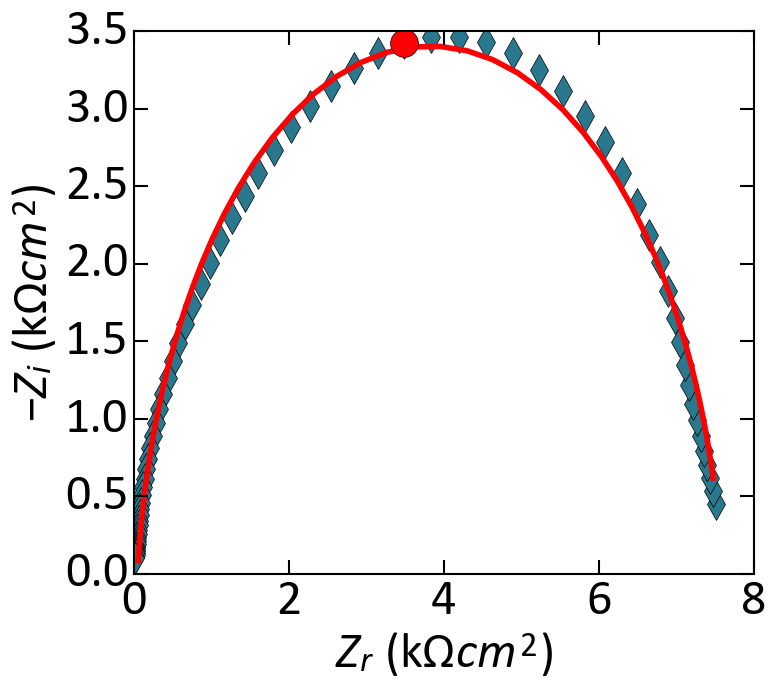

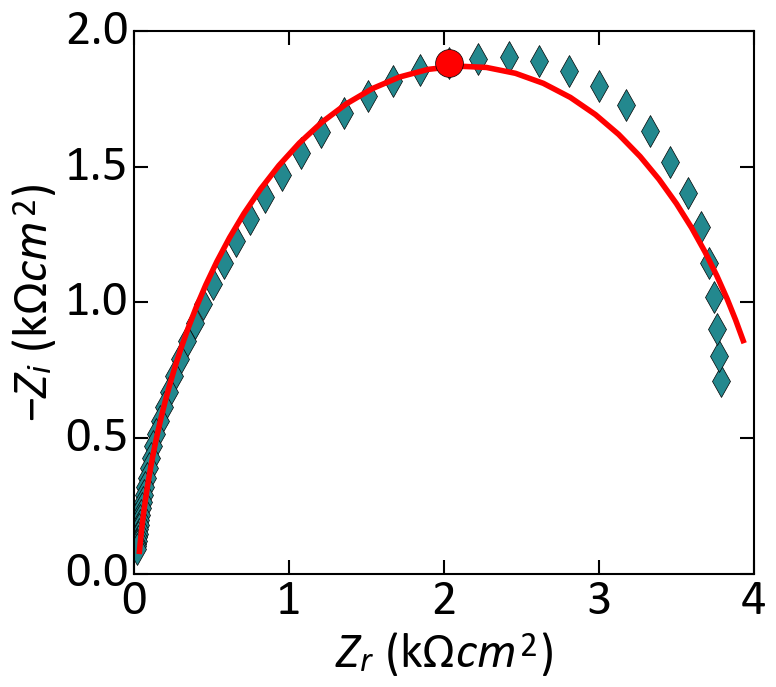

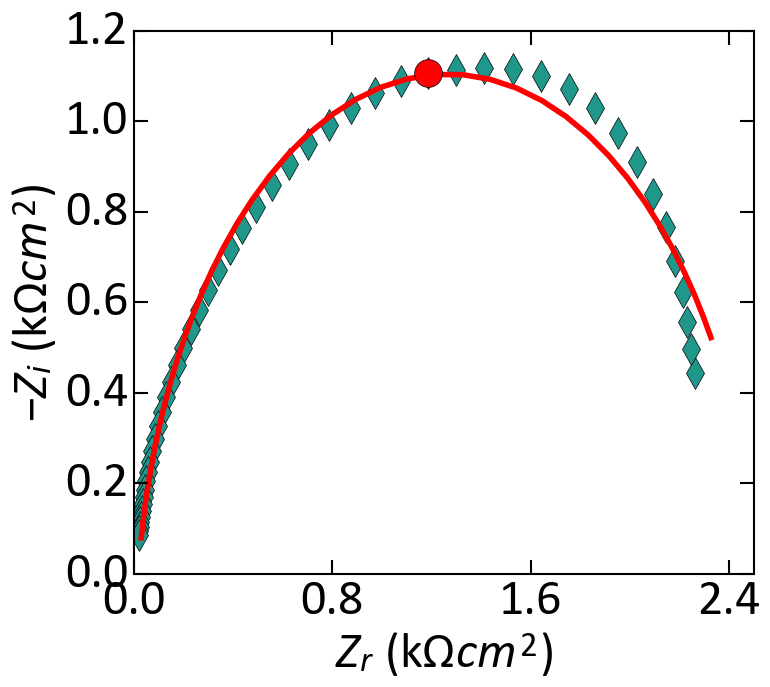

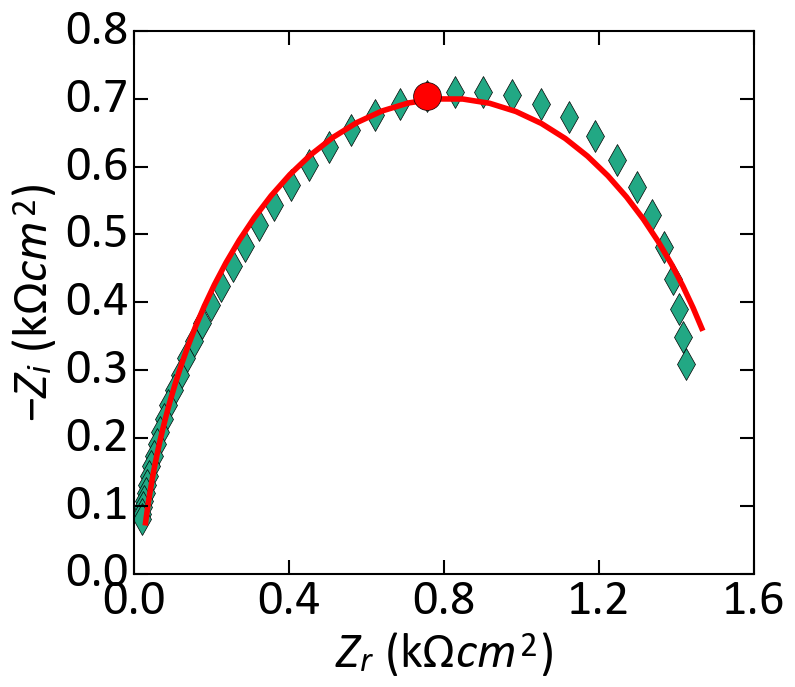

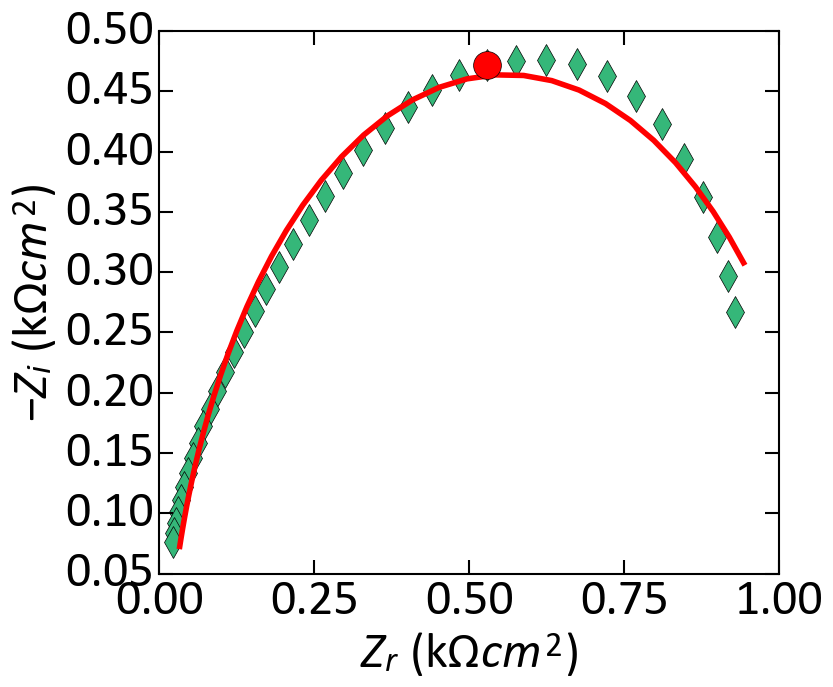

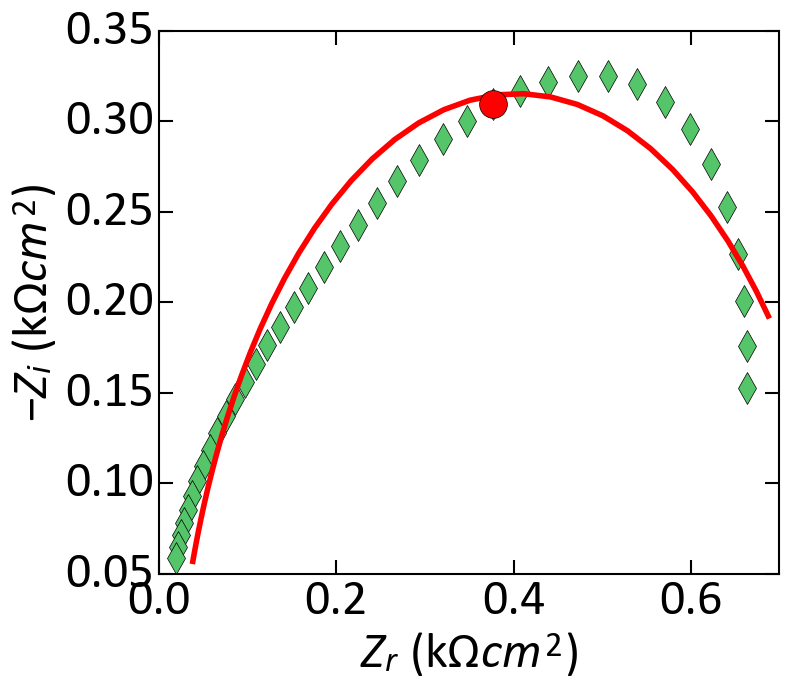

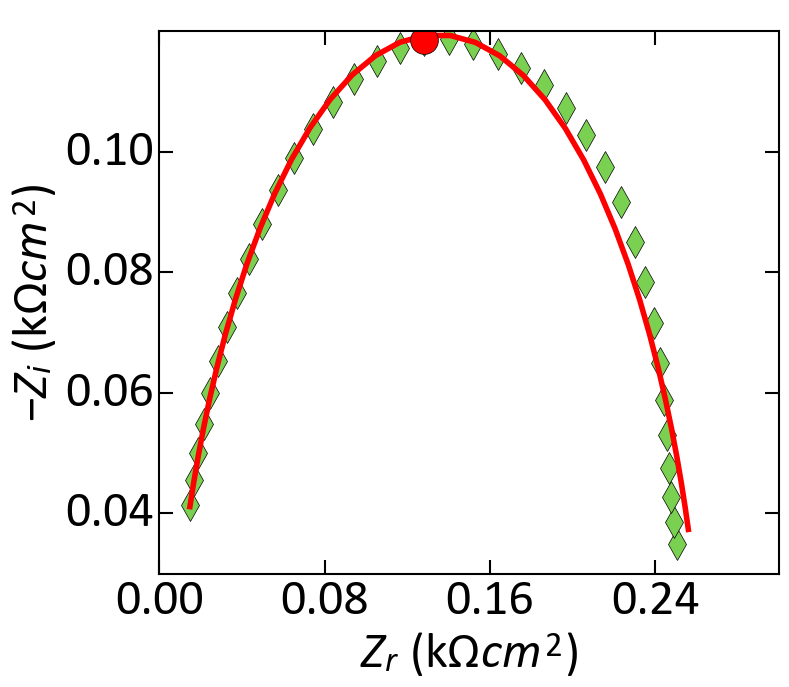

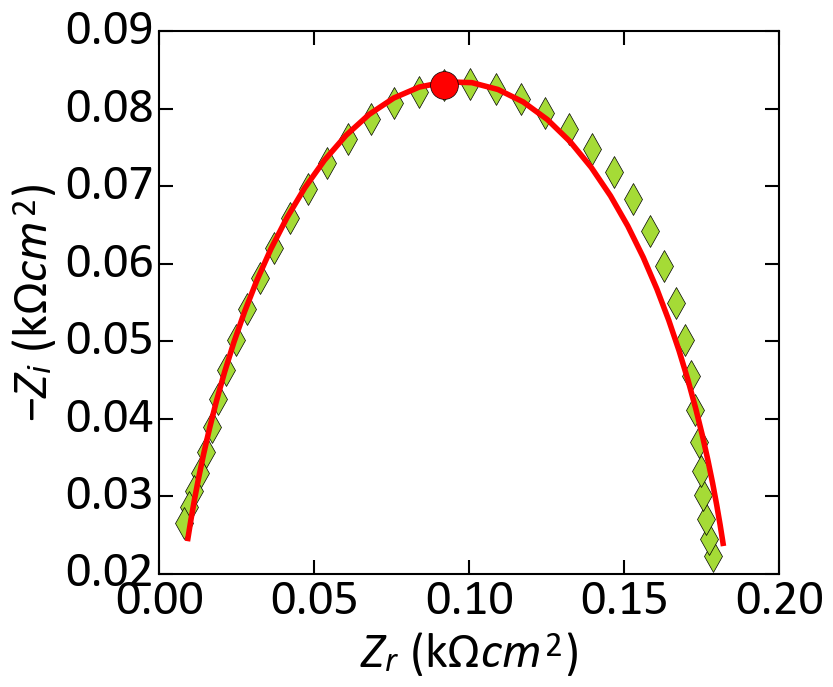

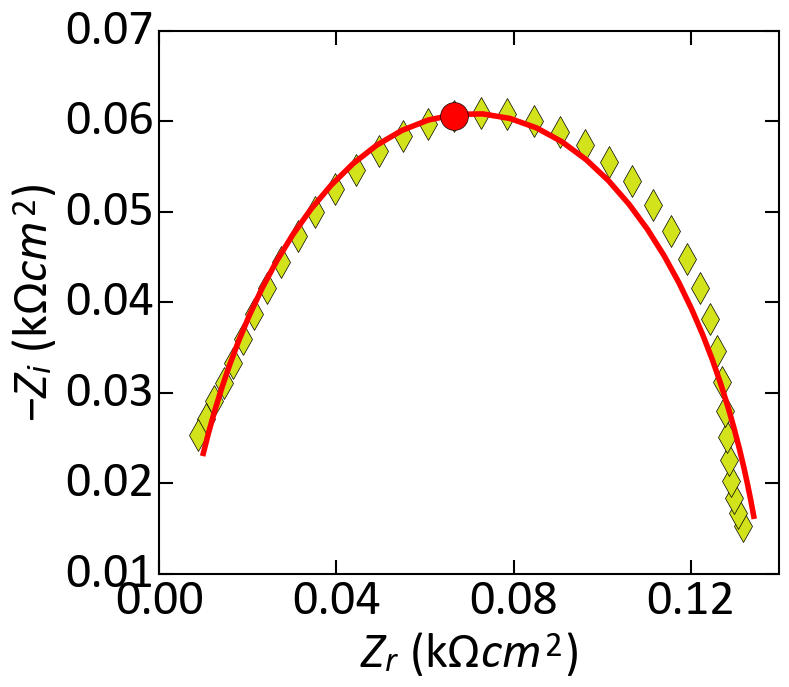

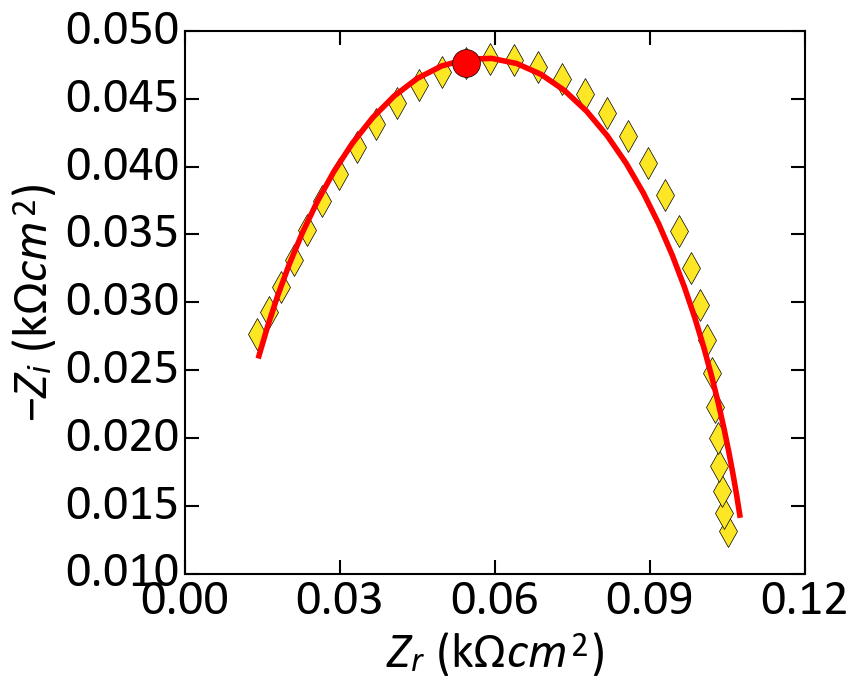

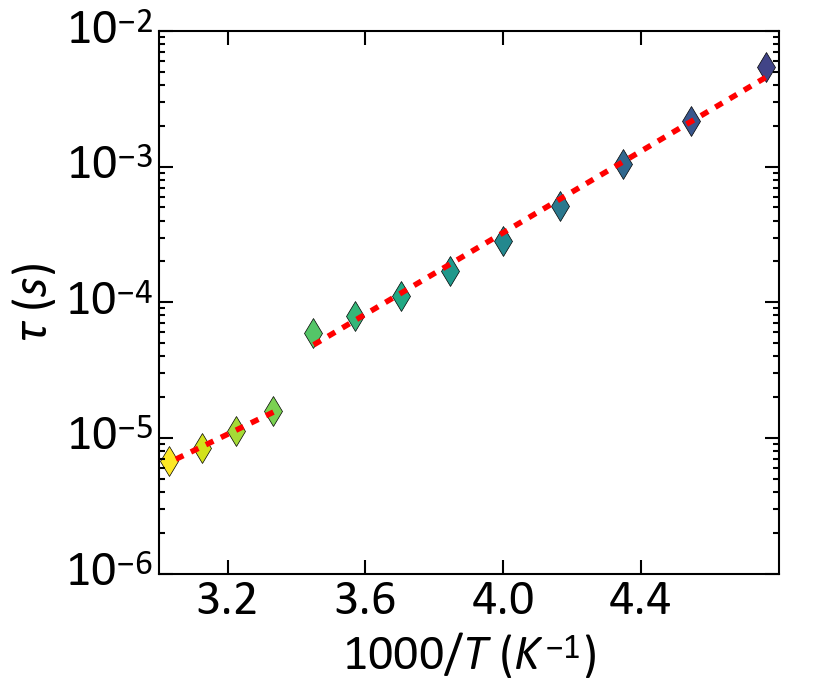

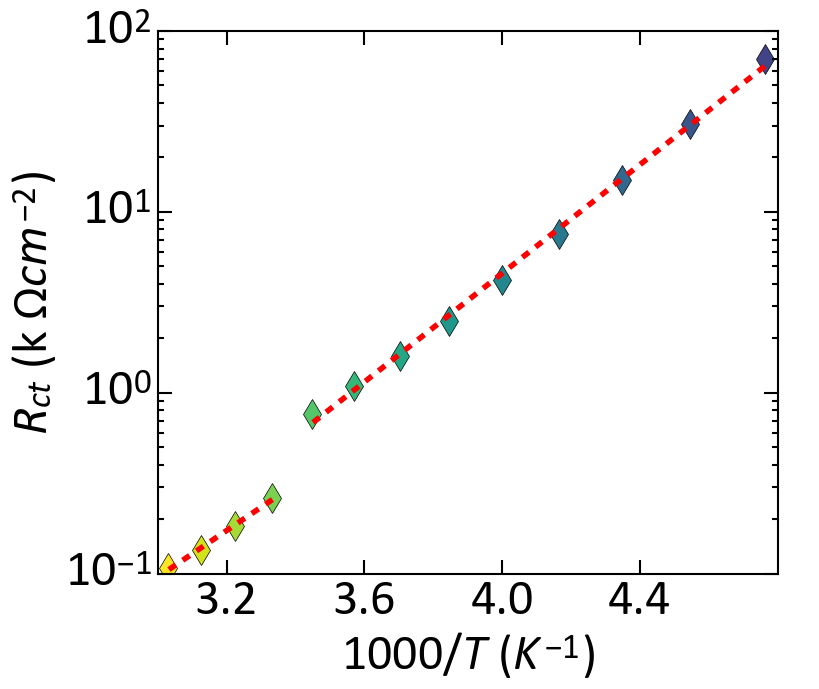

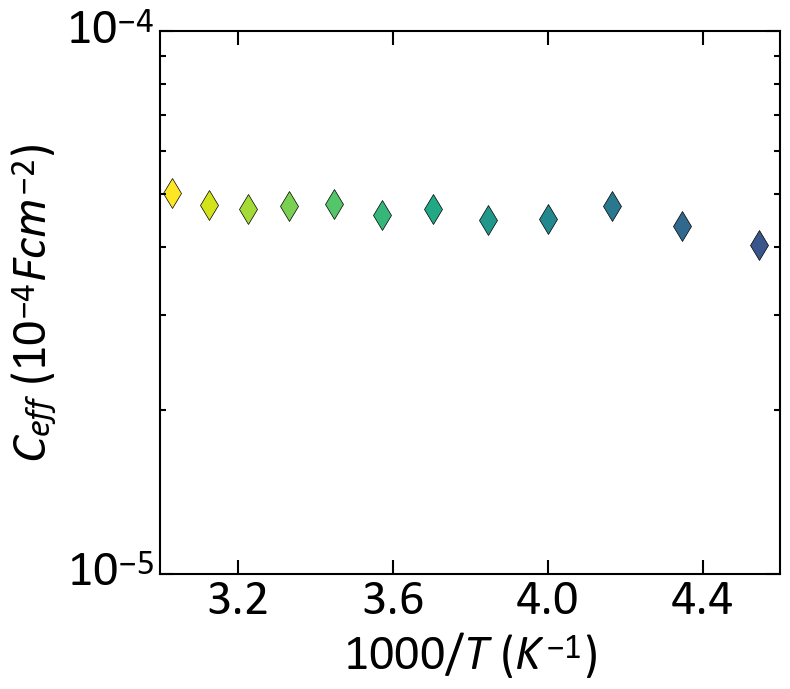

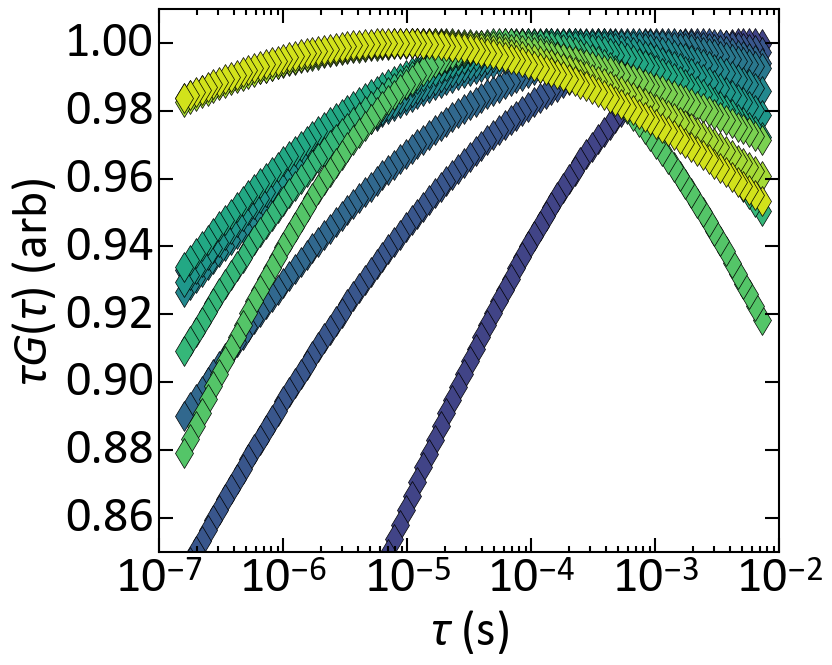

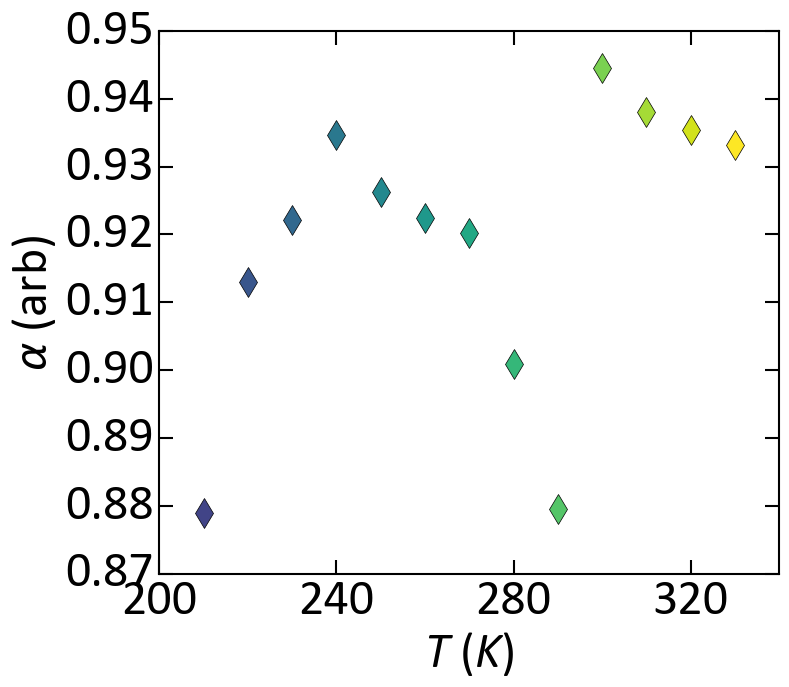

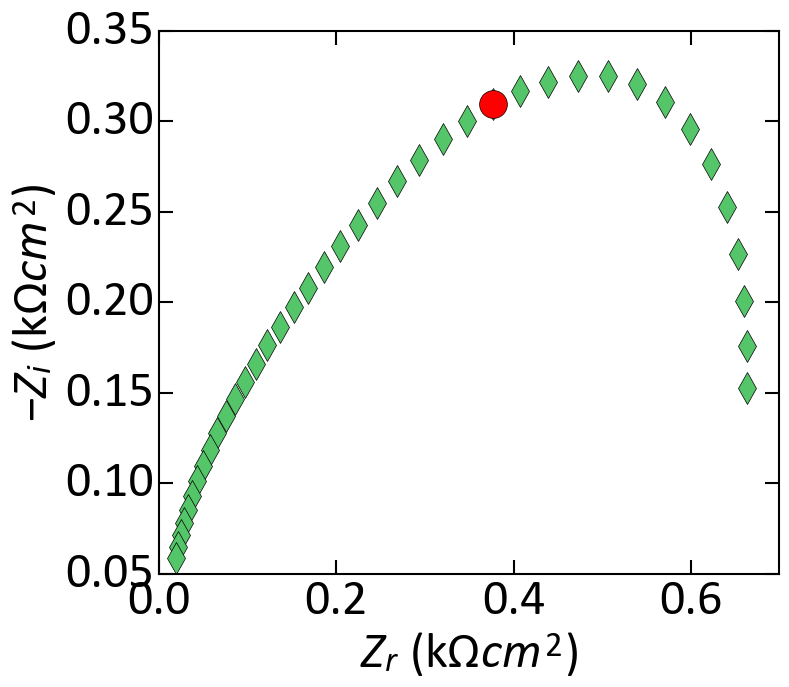

In [37]:

# arcs and fits

figDir2 = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\ligand_manuscript\currentVersion\TBAI\impedance\d2'
# figDir = r'C:\Users\Eric\Desktop\Lab_Work\admittance\ligand_and_interface\ligand_manuscript\currentVersion\TBAI\impedance\d2'

for t in range(3,tmax):
    fig,ax = plt.subplots(1,1, figsize = (8,7))
    ax.plot(Zr(t)[bounds1[t-3]:bounds2[t-3]],-Zi(t)[bounds1[t-3]:bounds2[t-3]],'d', color = tuple(colSet[t]))
    
    ax.plot(np.real(fitResults[t-3].best_fit),-np.imag(fitResults[t-3].best_fit),color = 'r')


    ax.plot(Zr(t)[wt0[t-3]],-Zi(t)[wt0[t-3]],'ro', markersize = 20)

    ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
    ax.set_ylabel("$-Z_{i}$ (k$\Omega cm^{2})$")
    ax.xaxis.set_major_locator(MaxNLocator(4))
#     figName = '\\Zfit_'+ np.array2string(T[t].astype(int)) + '.png'
#     plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')

# plot tau data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax):
    ax.plot(1e3/T[t],tau[t-3],'d',color=tuple(colSet[t]),markersize = 15)

ax.plot(1e3/T[Tt:Tc],tauLine1[:],color = 'r',linestyle='dashed' )
ax.plot(1e3/T[Tc:],tauLine2[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\tau$ ($s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\tau_arrheniusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# plot Rct data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax):
    ax.plot(1e3/T[t],RctFits[t-3],'d',color=tuple(colSet[t]),markersize = 15)

ax.plot(1e3/T[Tt:Tc],rLine1[:],color = 'r',linestyle='dashed' )
ax.plot(1e3/T[Tc:],rLine2[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$R_{ct}$ (k $\Omega cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
# figName = '\\R_arrhenhiusFit.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# plot C data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(4,tmax):
    ax.plot(1e3/T[t],Ceff[t-3],'d',color=tuple(colSet[t]),markersize = 15)

# ax.plot(1e3/T[Tt:],cLine[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$C_{eff}$ ($10^{-4}F cm^{-2}$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])
# ax.set_ylim([0,4])
figName = '\\C_arrhenhiusFit.png'
plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# # now plot the G function, which is a power law function of \tau
# fig,ax = plt.subplots(1,1, figsize = (8,7))
# for t in range(0,12):
#     ax.plot(tauArray[:],tGnorm[:,t],'d', markersize = 15,color = tuple(colSet[t+3]))
# ax.set_xlabel("$\\tau$ (s)")
# ax.set_ylabel("$\\tau G(\\tau)$ (arb)")
# ax.set_xscale("log") 
# # ax.set_yscale("log") 
# ax.set_ylim([0.85,1.01]);
# # figName = '\\Gdist_lowT.png'
# # plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# now plot the G function, which is a power law function of \tau
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(0,12):
    ax.plot(tauArray[:],tGnorm[:,t],'d', markersize = 15,color = tuple(colSet[t+3]))
ax.set_xlabel("$\\tau$ (s)")
ax.set_ylabel("$\\tau G(\\tau)$ (arb)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_ylim([0.85,1.01]);
# ax.set_xlim([-1,1e-3]);
# figName = '\\Gdist_allT.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

# plot tau data and fit
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax):
    ax.plot(T[t],alphaFits[t-3],'d',color=tuple(colSet[t]),markersize = 15)

ax.set_xlabel("$T$ ($K$)")
ax.set_ylabel("$\\alpha$ (arb)")
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.set_xlim([200,340])
# ax.set_ylim([0,4])
# figName = '\\alpha_T.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')


# turnover arc where 2 processes are competitive
fig,ax = plt.subplots(1,1, figsize = (8,7))
ax.plot(Zr(11)[bounds1[11-3]:bounds2[11-3]],-Zi(11)[bounds1[11-3]:bounds2[11-3]],'d', color = tuple(colSet[11]))

#     ax.plot(np.real(fitResults[t-3].best_fit),-np.imag(fitResults[t-3].best_fit),color = 'r')


ax.plot(Zr(11)[wt0[11-3]],-Zi(11)[wt0[11-3]],'ro', markersize = 20)

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ (k$\Omega cm^{2})$")
ax.xaxis.set_major_locator(MaxNLocator(4))
# figName = '\\arc_Compete_'+ np.array2string(T[11].astype(int)) + '.png'
# plt.savefig(figDir2 + figName,dpi = 300,bbox_inches = 'tight')

    


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


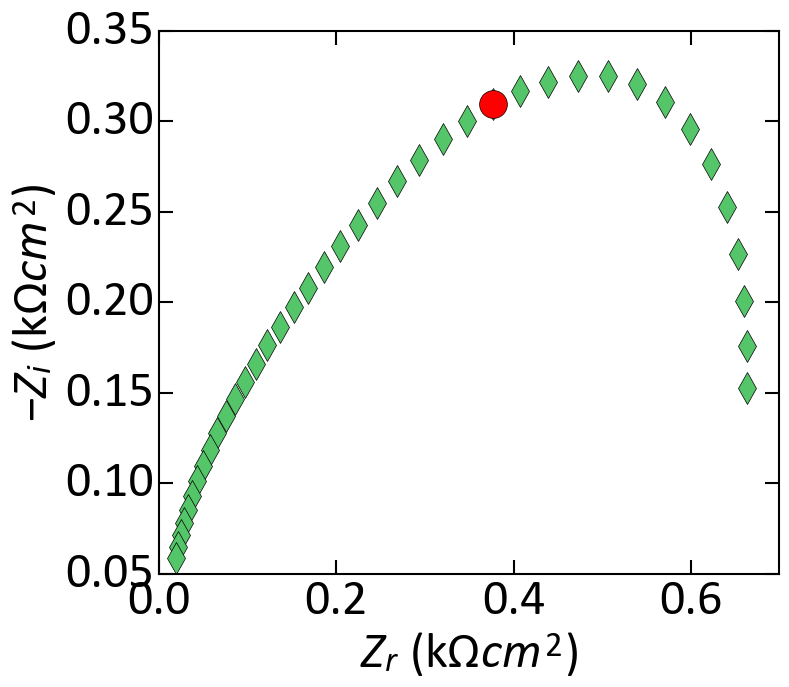

In [88]:
fig,ax = plt.subplots(1,1, figsize = (8,7))
ax.plot(Zr(11)[bounds1[11-3]:bounds2[11-3]],-Zi(11)[bounds1[11-3]:bounds2[11-3]],'d', color = tuple(colSet[11]))

#     ax.plot(np.real(fitResults[t-3].best_fit),-np.imag(fitResults[t-3].best_fit),color = 'r')


ax.plot(Zr(11)[wt0[11-3]],-Zi(11)[wt0[11-3]],'ro', markersize = 20)

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ (k$\Omega cm^{2})$")
ax.xaxis.set_major_locator(MaxNLocator(4))

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


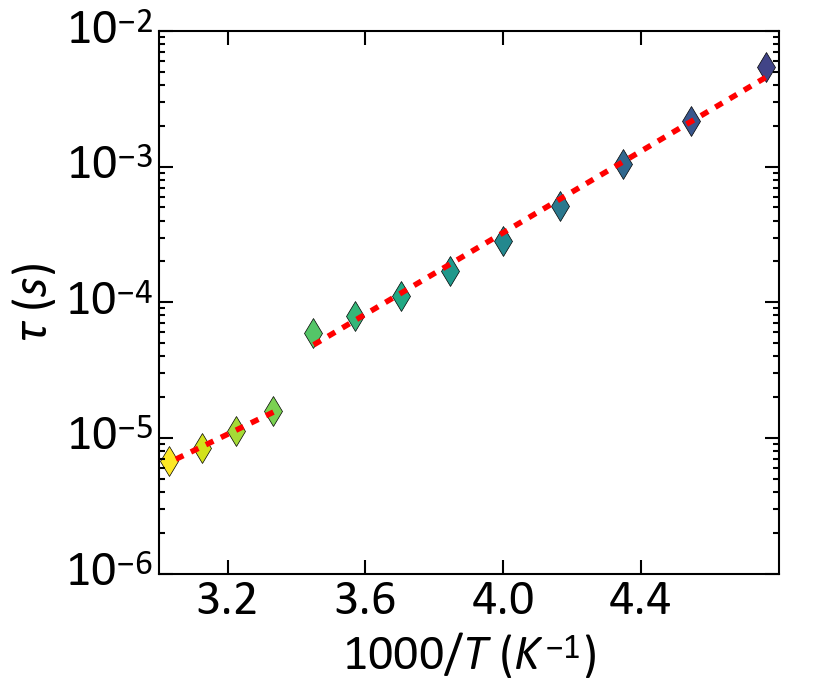

In [90]:
fig,ax = plt.subplots(1,1, figsize = (8,7))
for t in range(3,tmax):
    ax.plot(1e3/T[t],tau[t-3],'d',color=tuple(colSet[t]),markersize = 15)

ax.plot(1e3/T[Tt:Tc],tauLine1[:],color = 'r',linestyle='dashed' )
ax.plot(1e3/T[Tc:],tauLine2[:],color = 'r',linestyle='dashed' )

ax.set_xlabel("$1000/T$ ($K^{-1}$)")
ax.set_ylabel("$\\tau$ ($s$)")
# ax.set_xscale('log')
ax.set_yscale('log')
# ax.yaxis.set_major_locator(MaxNLocator(4))
ax.xaxis.set_major_locator(MaxNLocator(5))
# ax.set_xlim([180,300])

In [38]:
1/3.771e5

2.6518164942985944e-06

In [39]:
kB*330

0.0284361